In [3]:
import pandas as pd
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

#plt.xticks(rotation=60,fontsize=13)

<Figure size 1152x504 with 0 Axes>

In [581]:
#desc(data)
#plot_confusion_matrix(cm):

def desc(data):
    from sklearn.preprocessing import normalize
    unique_val=pd.DataFrame(index=data.columns)
    def obtain_variance(data):
        
        if data.dtypes in ('float64','int64'):
             xy1= pd.DataFrame(np.array(data*1.0))
             # variance values less than 0.006 ( threash hold), drop the column
            # If it is categorical binary column and if values 95:5 ratio, you drop the variable.
            #If it is continuous column and variance is less than 0.0066, you drop the variable (remember 0.0066 is value obtained after normalizing the variable).

             return "%3g"%xy1.var()[0]
        elif data.dtypes =='object':
            xy1= pd.DataFrame(data)
            xy1.reset_index()
    def obtain_std(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).std()[0]
    def obtain_mean(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).mean()[0]
    def obtain_min(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).min()[0]
    def obtain_max(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).max()[0]
    for i in data.columns:
        unique_val.loc[i,'dtypes']=data[i].dtypes
        unique_val.loc[i,'null_count']=data[i].isnull().sum() 
        unique_val.loc[i,'total_count']=data[i].notnull().sum()
        unique_val.loc[i,'unique_count']=data[i].nunique()
        unique_val.loc[i,'missing value ratio']="%0.2g" %(data[i].isnull().sum()/len(data)) +'%'
        unique_val.loc[i,'variance of numerics']= obtain_variance(data[i])
        unique_val.loc[i,'std']= obtain_std(data[i])
        unique_val.loc[i,'mean']= obtain_mean(data[i])
        unique_val.loc[i,'min']= obtain_min(data[i])
        unique_val.loc[i,'mean']= obtain_max(data[i])
    return unique_val.sort_values(by=['unique_count','null_count'])

def plot_confusion_matrix(cm):
    plt.figure(figsize=[9, 6])
  
    df_cm = pd.DataFrame(
        cm, index=['Actual: No','Actual: Yes'], columns=['Predicted: No','Predicted: Yes']
    )
    dd= pd.DataFrame(np.array([['TP','FN'],['FP','TN']]))
    print(dd)
    #sns.heatmap(np.array([['TP','FP'],['FN','TN']]), annot=True, annot_kws={"size": 20},fmt='g', yticklabels=False)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20},fmt='g', yticklabels=False,xticklabels=False)
    #plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Actual False      Actual True', fontsize=18)
    plt.ylabel('Predicted True           Predicted False', fontsize=18)
    
def plot_roc_curve(model,X,Y):
    from sklearn.metrics import roc_curve
    pred = model.predict_proba(X)[:,1]

    fpr, tpr, _ = roc_curve(Y,pred) 
    auc = roc_auc_score(Y, pred) 

    #print(fpr,tpr,auc)
    
    plt.figure(figsize=(12,8)) 
    plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.legend(loc=4) 

def plot_pr_curve(model,X,Y):
    fig= plt.figure(figsize=(12,7))
    probas = model_lr.predict_proba(X)[:,1]
    pred = model_lr.predict(X)

    #fpr, tpr, _ = roc_curve(Y,pred) 
    precision, recall, thresholds = precision_recall_curve(Y, probas)
    f1 = f1_score(Y, pred)
    auc_s = auc(recall, precision)
    #f1,auc
    print(recall[:])
    print('Logistic: f1=%.3f auc=%.3f' % (f1, auc_s))
    no_skill=len(Y[Y==1]) / len(Y)
    plt.plot([0, 1], [no_skill, no_skill], marker='^',linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.ylabel('Precison',fontsize=25) 
    plt.xlabel('Recall',fontsize=25)
    plt.legend(loc=4)
    
def classificationModelfit_CV(ml_model,dataframe, Y,cols, rstate = 12, thres = 0.5,  plotROC=0):
    i = 1
    roc_scores = []
    tpr_scores=[]
    fpr_scores=[]
    precision_scores=[]
    recall_scores=[]
    confusion_matrix_scores=[]
    accuracy_scores=[]
    f1_scores=[]
    PRCprecisions=[]
    PRCrecalls=[]
    PRCauc_scores=[]
    Number_of_Trues=[]
    df1 = dataframe.copy()
    df1 = dataframe[cols]
    cv_scoredf=pd.DataFrame()
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,Y):
        
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = Y.loc[df_index],Y.loc[test_index]
        #print(xtr.shape,xvl.shape,ytr.shape,yvl.shape)
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
        
        #plot_roc_curve(model,xtr,ytr)
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        
        # ROC Matrix Data
        fpr, tpr, ROC_Threshholds = roc_curve(yvl,pred_probs[:,1]) 
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        accuracy_score1 = accuracy_score(yvl,pred_val)
        
        # Precession Recall matrix Data
        PRCprecision, PRCrecall, _ = precision_recall_curve(yvl, pred_probs[:,1])
        f1_sc = f1_score(yvl, pred_val)
        Number_of_True=len(yvl[yvl==1]) / len(yvl)
        PRCauc= auc(PRCrecall,PRCprecision)
        
        cm=confusion_matrix(yvl,pred_val)
        if plotROC==3:
            plot_confusion_matrix(cm)
         # Save scores

        roc_scores.append(roc_score)
        fpr_scores.append(fpr)
        tpr_scores.append(tpr)
        recall_scores.append(recall)
        precision_scores.append(precision)
        confusion_matrix_scores.append(cm)
        accuracy_scores.append(accuracy_score1)
        f1_scores.append(f1_sc)
        PRCprecisions.append(PRCprecision)
        PRCrecalls.append(PRCrecall)
        Number_of_Trues.append(Number_of_True)
        PRCauc_scores.append(PRCauc)
        
        i+=1   
    cv_scoredf['fpr_scores'] =fpr_scores
    cv_scoredf['tpr_scores'] =tpr_scores
    cv_scoredf['roc_scores'] =roc_scores
    cv_scoredf['recall_scores'] =recall_scores
    cv_scoredf['precision_scores'] =precision_scores
    cv_scoredf['confusion_matrix_scores']=confusion_matrix_scores
    cv_scoredf['accuracy_scores'] =accuracy_scores
    cv_scoredf['f1_scores'] =f1_scores
    cv_scoredf['PRCprecisions'] =PRCprecisions
    cv_scoredf['PRCrecalls'] =PRCrecalls
    cv_scoredf['Number_of_Trues'] =Number_of_Trues
    cv_scoredf['PRCauc_scores'] =PRCauc_scores
    
    
    if plotROC==1:
        plt.figure(figsize=(26,10))
        plt.title("""   ROC(Reciever Operating) Curve
    (Cross Validation)
    """,color='blue')
        #plt.plot(fpr,tpr,label="Non-CV AUC-ROC="+str("%  0.2f"%auc), linewidth=7,color='magenta') 
        for i in range(5):
            x = np.linspace(0, 1, 1000)
            plt.plot(x, x, linestyle='-')
            
            plt.plot(fpr_scores[i],tpr_scores[i],label="CV set=%i, Accuracy=%0.2f, AUC= %0.2f, Recall=%0.2f, Precison=%0.2f"
                     %(i,accuracy_scores[i],roc_scores[i],recall_scores[i],precision_scores[i])
                     ) 
            plt.legend(loc=4,fontsize=25)
            plt.xlabel('False Positive Rate') 
            plt.ylabel('True Positive Rate')          
    
    elif plotROC==2:  
        plt.figure(figsize=(26,10))
        plt.title("""   Precision Recall Curve
    (Cross Validation)
    """,color='blue')
        plt.plot([0, 1], [Number_of_Trues[0], Number_of_Trues[0]], marker='^',linestyle='--', label='Number of true values=%0.2f' %Number_of_Trues[0])

        for i in range(5):
                #  print("CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, Number_of_Trues=%0.2f, prcAUC_scores=%0.2f "
                #       %(i, accuracy_scores[i], f1_scores[i], Number_of_Trues[i], PRCauc_scores[i]  ))
                
                plt.plot(PRCrecalls[i],PRCprecisions[i], marker='.', 
                         label="CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, prcAUC_scores=%0.2f,Recall=%0.2f, Precison=%0.2f "
                      %(i, accuracy_scores[i], f1_scores[i], PRCauc_scores[i],recall_scores[i],precision_scores[i]  ))
                plt.ylabel('Precison',fontsize=25) 
                plt.xlabel('Recall',fontsize=25)
                plt.legend(loc=4,fontsize=25)         
    else:
        for i in range(5):
            print('\n{} of kfold {}'.format(i,kf.n_splits))
            sufix = ""
            msg = ""
            msg += "CV1 set=%i,Accuracy=%0.2f, AUC= %0.2f, Recall=%0.2f, Precison=%0.2f"%(i,accuracy_scores[i],roc_scores[i],recall_scores[i],precision_scores[i])
            print("{}".format(msg))
            print(confusion_matrix_scores[i])
            print("CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, Number_of_Trues=%0.2f,prcAUC_scores=%0.2f, Recall=%0.2f, Precison=%0.2f"
              %(i,accuracy_scores[i],f1_scores[i],Number_of_Trues[i], PRCauc_scores[i],recall_scores[i],precision_scores[i] ))
            
    return cv_scoredf

def regressionModelfit_CV(alg, cols,  x, y):
    #Fit the algorithm on the data
  
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import cross_validate
    xdata= x[cols]
    ydata=y
    alg.fit(xdata, ydata)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xdata)

    
    cv_score = cross_val_score(alg, xdata, ydata, cv=4,scoring= 'neg_mean_squared_error')
    #Perform cross-validation:
    cv_matrix_score= cross_validate(alg, xdata, ydata, cv=4,scoring=(
                         'r2', 
                         'neg_mean_absolute_error',
                         'neg_mean_squared_error'
                         ),
                         return_train_score=True)
    #return cv_matrix_score
    avg_model_Scores=pd.DataFrame(cv_matrix_score).mean()
    for i in avg_model_Scores.index:
        if 'neg' in i :
            print("%s =%0.2f" %(i, np.sqrt(avg_model_Scores[i]*-1) ))
        else:
            print("%s =%0.2f" %(i, avg_model_Scores[i] ))
    #dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    #submission.to_csv(filename, index=False)

def getLinearModelScore(_model, xTraingingData,yTraingingData,columnlist):
    xTraingingData=xTraingingData[columnlist]
    x_train, x_test, y_train, y_test = train_test_split(traingingData,yTraingingData, test_size =0.3)
    _model.fit(x_train, y_train)
    ptrain = _model.predict(x_train)
    ptest = _model.predict(x_test)
    
    
    

In [5]:
# Univariate Categorical columns plots

    # makeUnivariateCategoricalplotBARV(catColList, dataFrame):
    # makeUnivariateCategoricaPlotPIE(catColList, dataFrame):
    #crossTabHistGramPlotSplit(CatColList, BinaryValColumn, Dataframe):
    #Bivariate_ContiList_over_CataList_mean_CheckOrdinality(ContiList, CatList,DataFrame)
    #crossTabHistGramPlot(CatColList, BinaryValColumn, Dataframe)

def makeUnivariateCategoricalplotBARV(catColList, dataFrame):
    """Bar graph is a pictorial representation of data that uses bars to compare different categories of data.
       Comparison of discrete variables
       Bars do not touch each other, hence there are spaces between bars.
       Elements are taken as individual entities.
       Bars can be reordered
       Each  vertical bar graph represents time series data.
       It contains two axis, where one axis represents the categories and the other axis shows the discrete values of the data
    """
    
    """
      Large Categorical Needs to be numerical
    """
    #print(" Lets create Horizontal BAR plot for column " )
    #print(catColList)
    #sns.countplot(column)
    #sns.boxplot(column)
    plt1 = plt
    plt1.grid
    j = 430
    i = 1
    fig = plt1.figure(figsize=(30, 40))
    plt1.suptitle("Univariate Categroical Analysing using Horizontal BAR  for the following Columns",fontsize=30)
    
    for colname in catColList:
        column = dataFrame[colname]
        
        _len=dataFrame[colname].nunique()
        plt1.subplot(i + j)
        i = i + 1 
        plt1.yticks( fontsize=30)
        plt1.title(colname,fontsize=40,color='magenta')
        plt1.ylabel("count for each category",fontsize=30)    
        if _len> 10:
            print(colname,_len)
            dataFrame[colname].dropna().apply(lambda x :int(x)).plot.hist(bins=10)
            plt.xticks( fontsize=30, rotation=15)
        else:
            
            data = column.value_counts(ascending=True)
            N = data.count()
            x = np.arange(N)
            colors = np.random.rand(N * 4).reshape(N, -1)
            plt1.xticks(x, data.index, fontsize=30, rotation=15)
            print("dalwinder")
            plt1.bar(x, data, alpha=1, color=colors)#, tick_label=labels)

    plt1.show()

def makeUnivariateCategoricaPlotPIE(catColList, dataFrame):

    #print(" Lets create pie plot for following columns ")
    #print(catColList)

    #sns.countplot(column)
    #sns.boxplot(column)
    plt1 = plt
    j = 430
    i = 1
    fig = plt1.figure(figsize=(30, 30))
    plt1.rcParams['font.size'] = 9.0
    plt1.suptitle("Categorical Column analysis with Pie Chart",fontsize=30)
    for colname in catColList:
        column = dataFrame[colname]
        data = column.value_counts()
        #N = data.count()
        #x = np.arange(N)
        #print("data ", data)
        plt1.subplot(j + i)
        i = i + 1
        #plt1.title("pie Chart")
        #plt1.grid(True)
        
        plt1.pie(data, labels=data.index, autopct='%1.1f%%',textprops={'fontsize': 20})
        plt1.axis('equal')
        plt1.xticks(fontsize=30)
        plt1.yticks(fontsize=30)
        plt1.xlabel(colname,fontsize=30)
        plt1.legend(loc=2,fontsize=20)
    plt1.show()

def crossTabHistGramPlotSplit(CatColList, BinaryValColumn, Dataframe):
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    plt1.suptitle("Catagorical Cols Analysis with status/label columns " + BinaryValColumn)
    for colname in CatColList:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        CreditHistory_loanStatus = pd.crosstab(Dataframe[colname], Dataframe[BinaryValColumn])
        CreditHistory_loanStatus.plot(kind='bar', color=['red', 'blue'], grid=False, ax = ax1)
        plt1.xticks(rotation=12,fontsize=25)
        plt1.xlabel(colname,fontsize=25)
        plt1.ylabel(BinaryValColumn)
        
        plt1.legend(fontsize=20)
        #plt1.title(colname)
    plt1.show()

def Bivariate_ContiList_over_CataList_mean_CheckOrdinality(ContiList, CatList,DataFrame):
    plt1 = plt
    for colname in CatList:
        data.groupby(colname)[ContiList].mean().plot(kind='bar',figsize=(28,10),stacked=False)
        plt1.xticks(fontsize=25, rotation=15)
        plt1.yticks(fontsize=25, rotation=35)
        plt1.ylabel("Avg (Contineos Cols) as Bars",fontsize=35,color='magenta')
        plt1.legend(ContiList,fontsize=18)
        plt1.xlabel(colname + ' Classes',fontsize=35,color='magenta')
        
def crossTabHistGramPlot(CatColList, BinaryValColumn, Dataframe):
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    plt1.suptitle("Catagorical Cols Analysis with status/label columns " + BinaryValColumn)
    for colname in CatColList:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        CreditHistory_loanStatus = pd.crosstab(Dataframe[colname], Dataframe[BinaryValColumn])
        CreditHistory_loanStatus.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False, ax = ax1)
        plt1.xticks(rotation=12,fontsize=25)
        plt1.xlabel(colname,fontsize=25)
        plt1.ylabel(BinaryValColumn)
        
        plt1.legend(fontsize=20)
        #plt1.title(colname)
    plt1.show()

    



In [6]:
# Univaricate Contineous columns plots

  # Univariate_conti_var_Histogram(catColList, dataFrame)
  # Univariate_conti_var_Box(catColList, dataFrame):
  # SNS_BoxSubplots_univaricate_Contineous(conti_col,df):
  # SNS_dist_subplots_univaricate_Contineous(conti_col,df):

def Univariate_conti_var_Histogram(catColList, dataFrame):
    print(" Lets create Vertical Multi HISTOGRAM plot for column ")
    print(catColList)
    # sns.countplot(column)
    # sns.boxplot(column)
    """A histogram is a plot of the frequency distribution of numeric array by splitting it to small equal-sized bins.

    """
    plt1 = plt
    j = 430
    i = 1
    fig = plt1.figure(figsize=(30, 40))
    plt1.suptitle("Univariate Contineous Variable Analyses using HISTOGRAM for following columns ")
    for calname in catColList:
        column = dataFrame[calname]
        num_bins = 30  # column.value_counts().max() / column.count() * 2
        
        j = i + j
        plt1.subplot(j) 
        plt1.xticks(fontsize=30, rotation=15,color='red')
        plt1.yticks(fontsize=25,color='magenta')
        plt1.hist(column, num_bins, facecolor='blue',density=1, alpha=0.5)
        plt1.title(calname,fontsize=30,color='blue')
        
        # Use 'density' instead.
    plt1.show()
    
def Univariate_conti_var_Box(catColList, dataFrame):
    print(" Lets create Vertical Multi HISTOGRAM plot for column ")
    print(catColList)
    # sns.countplot(column)
    # sns.boxplot(column)
    """A histogram is a plot of the frequency distribution of numeric array by splitting it to small equal-sized bins.

    """
    plt1 = plt
    j = 430
    i = 1
    fig = plt1.figure(figsize=(30, 40))
    plt1.suptitle("Univariate Contineous Variable Analyses using HISTOGRAM for following columns ")
    for calname in catColList:
       
        num_bins = 30  # column.value_counts().max() / column.count() * 2
        
        j = i + j
        plt1.subplot(j)
        
        dataFrame[calname].plot.box() 
        plt1.xticks(fontsize=30, rotation=15)
        #plt1.hist(column, num_bins, facecolor='blue',density=1, alpha=0.5)
        plt1.title(calname)
        
        # Use 'density' instead.
    plt1.show()
def SNS_BoxSubplots_univaricate_Contineous(conti_col,df):
    k=0
    sns.set(font_scale=3)
    import math
    rows= int(math.ceil(len(conti_col)**1/3))
    fig, axs =  plt.subplots(rows,3,figsize=(30, 12))
    #fig, axs =  plt.subplots(1,3,figsize=(40, 30))
    plt.rc('legend',fontsize=10)
    conti_col
    if rows <=1:
        for i in range(1):
           for j in range(3):
             #print(i,j,k)
             k = k+1
             #df[conti_col[k-1:k]].plot.box(figsize=(20,30),ax=axs[i,j])
             sns.violinplot(data=df[conti_col[k-1:k]],ax=axs[j])
    else:
        for i in range(rows):
           for j in range(3):
             if k < len(conti_col):
                 k = k+1
                 sns.violinplot(data=df[conti_col[k-1:k]],ax=axs[i,j])
def SNS_dist_subplots_univaricate_Contineous(conti_col,df):
    k=0
    sns.set(font_scale=3)
    import math  
    rows= int(math.ceil(len(conti_col)**1/3))
    fig, axs =  plt.subplots(rows,3,figsize=(30, 10))
    #fig, axs =  plt.subplots(1,3,figsize=(40, 30))
    plt.rc('legend',fontsize=10)
    conti_col
    if rows <=1:
        for i in range(1):
           for j in range(3):
             k = k+1
             sns.distplot(df[conti_col[k-1:k]],ax=axs[j],kde=True ) 
    else:
        for i in range(rows):
           for j in range(3):
             if k < len(conti_col):
                 k = k+1
                 sns.distplot(df[conti_col[k-1:k]],ax=axs[i,j],kde=True ) 


In [7]:
# Bivariaate Analysis
#Conti_Vs_Cat_Cols_BoxPlot(gpByCategroical_Col, contineoua_col_name, dataFrame):
#Conti_Vs_Cat_Cols_MeanValue_barplot(catColList,Contineous_col, dataFrame):
#Bivariate_Ana_Catogorical_over_ContiLabel_Pivotmean(groupColumn, Conti_label_column, Dataframe):

#crossTabHistGramPlotSplit(groupColumn, BinaryValColumn, Dataframe)
#crossTabHistGramPlot(groupColumn, BinaryValColumn, Dataframe):
#Bivariate_numericCol_Distribtion_overLabelClass(numeric_Conti_columnList,LabelColname,dataframe)

#correlation_heatmap(numeric_colList, dataframe)
#Bivariate_ana_conti_vs_Conti_label_scatter(conti_ColList,conti_label_name, dataFrame)



def Conti_Vs_Cat_Cols_BoxPlot(gpByCategroical_Col, contineoua_col_name, dataFrame):
    # 1. It create box plot for each group of data for the By column
    # 2. for Each group data of group column , it will count number of rangeColumn items based on item value and tell us
    #        which how many items and falling under what range fo values
    #  Box plot is used to identify the outliers
    """ boxplot() function takes
                #  first arguament as the data array to be plotted ,
                #  second argument patch_artist=True , fills the boxplot and
                #  third argument takes the label to be plotted.
    """
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(40,50))
    for colname in gpByCategroical_Col:
        #plt1.subplot(211)
        ax1 = plt1.subplot(i+j)
        i = i + 1
        
        dataFrame.boxplot(column=contineoua_col_name, by=colname, patch_artist=True, ax=ax1,fontsize=20)
        plt1.xlabel(colname+ "= cat col",fontsize=30)
        plt1.ylabel(contineoua_col_name + "= conti col",fontsize=30)
        plt1.title("")
        plt1.xticks(rotation=40)
        plt1.suptitle("Bivariate Analysis [contineos col, category col]  Via Box plot -  Distribution of over each category "  )
    plt1.show()
    
def Conti_Vs_Cat_Cols_MeanValue_barplot(catColList,Contineous_col, dataFrame):
    print(" Lets create Vertical Multi HISTOGRAM plot for column ")
    print(catColList)
    # sns.countplot(column)
    # sns.boxplot(column)
    """A histogram is a plot of the frequency distribution of numeric array by splitting it to small equal-sized bins.

    """
    plt1 = plt
    j = 430
    i = 1

    fig= plt1.figure(figsize=(40,30))
    plt1.suptitle("""Bivariate Analyses Category col: """ + str(catColList) +
                     
                  """\nMean of contineous columns using Bar Chart: """ + Contineous_col
                )
    for calname in catColList:
        column = dataFrame[calname]
        num_bins = 30  # column.value_counts().max() / column.count() * 2
        
        j = i + j
        plt1.subplot(j)
        dataFrame.groupby(calname)[Contineous_col].mean().plot.bar()
        plt1.xticks(fontsize=25,rotation=10)
        plt1.xlabel(calname+ "= cat col",fontsize=30)
        plt1.ylabel(" Average of " + Contineous_col ,fontsize=30)       
        #plt1.hist(column, num_bins, facecolor='blue',density=1, alpha=0.5)
        # Use 'density' instead.
    plt1.show()
    
# privotTabHistGramPlot renamed to Bivariate_Ana_Catogorical_over_ContiLabel_Pivotmean
def Bivariate_Ana_Catogorical_over_ContiLabel_Pivotmean(catCol_list, Conti_label_column, Dataframe):
    # privotTab is used 
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    plt1.suptitle("Avarage of %s columns  " + Conti_label_column + " over  each ")
    for colname in catCol_list:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        Dataframe.pivot_table(Conti_label_column,index=[colname],aggfunc=np.mean).plot.bar(ax=ax1)
        plt1.xticks(rotation=12,fontsize=25)
        plt1.xlabel(colname,fontsize=25)
        plt1.ylabel(Conti_label_column)
        
        plt1.legend(fontsize=20)
        #plt1.title(colname)
    plt1.show()
    

def crossTabHistGramPlotSplit(groupColumn, BinaryValColumn, Dataframe):
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    plt1.suptitle("Catagorical Cols Analysis with status/label columns " + BinaryValColumn)
    for colname in groupColumn:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        CreditHistory_loanStatus = pd.crosstab(Dataframe[colname], Dataframe[BinaryValColumn])
        CreditHistory_loanStatus.plot(kind='bar', color=['red', 'blue'], grid=False, ax = ax1)
        plt1.xticks(rotation=12,fontsize=25)
        plt1.xlabel(colname,fontsize=25)
        plt1.ylabel(BinaryValColumn)
        
        plt1.legend(fontsize=20)
        #plt1.title(colname)
    plt1.show()
def crossTabHistGramPlot(groupColumn, BinaryValColumn, Dataframe):
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    plt1.suptitle("Catagorical Cols Analysis with status/label columns " + BinaryValColumn)
    for colname in groupColumn:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        CreditHistory_loanStatus = pd.crosstab(Dataframe[colname], Dataframe[BinaryValColumn])
        CreditHistory_loanStatus.plot(kind='bar', stacked=True, grid=False, ax = ax1)
        plt1.xticks(rotation=12,fontsize=25)
        plt1.xlabel(colname,fontsize=25)
        plt1.ylabel(BinaryValColumn)
        
        plt1.legend(fontsize=20)
        #plt1.title(colname)
    plt1.show()


    
def Bivariate_numericCol_Distribtion_overLabelClass(numeric_Conti_columnList,LabelColname,dataframe):
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    
    #plt1.suptitle("Catagorical Cols Analysis with status/label columns " + numeric_Conti_columnList)

    group=['Low','Average','High', 'Very high']

    for conti_colname in numeric_Conti_columnList:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        
        _colData=pd.DataFrame({conti_colname: dataframe[conti_colname],
                               LabelColname: dataframe[LabelColname]
                              })
        #,index=[conti_colname,LabelColname]
        _n_cols=pd.qcut(dataframe[conti_colname],q=4,duplicates='drop').nunique()
        _colData['bin']=pd.qcut(dataframe[conti_colname], q=4,duplicates='drop',labels=group[:_n_cols])
        #print(_colData.bin.nunique())
        
        _crsTab=pd.crosstab(_colData['bin'],_colData[LabelColname])
        #print(crsTab)1222
        ax1.xaxis.set_label_position('top') 

        axd=_crsTab.div(_crsTab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,ax=ax1) 
        plt1.xlabel(conti_colname,fontsize=25,color='magenta') 
        plt1.xticks(fontsize=25,rotation=30)
        plt1.ylabel('% of '+ conti_colname + 'data per class',fontsize=20,color='red')
        plt1.legend(fontsize=25,loc=2)

def Bivariate_ana_conti_vs_Conti_label_scatter(conti_ColList,conti_label_name, dataFrame):
    print(" Lets create Vertical Multi HISTOGRAM plot for column ")
    print(conti_ColList)

    """A histogram is a plot of the frequency distribution of numeric array by splitting it to small equal-sized bins.

    """
    plt1 = plt
    j = 430
    i = 1
    fig = plt1.figure(figsize=(30, 10))
    plt1.suptitle("Univariate Contineous Variable Analyses using HISTOGRAM for following columns ")
    for colname in conti_ColList:
        j = i + j
        #plt1.subplot(j)
        
         
        
        plt1.xticks(fontsize=25, rotation=15)
        plt1.scatter(dataFrame[conti_label_name], dataFrame[colname], alpha=0.5)
        plt1.title(colname)
        
        
        # Use 'density' instead.
    plt1.legend(conti_ColList,fontsize=30)
    plt1.show()
    
def correlation_heatmap(numeric_colList, dataframe):
    corrs=dataframe.corr().abs()
    trimmedCorrs=corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(np.bool))
    print(trimmedCorrs)
    Corrs_drp=[ i for i in trimmedCorrs.columns if any(trimmedCorrs[i] > 0.6)]
    print("""\n\nDrop following highly correlated column Crossing the threashold values(0.6):
                                                """ + str(Corrs_drp)     +"\n\n"  )
    matrix = dataframe[numeric_colList].corr()  
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    fig, ax = plt.subplots(figsize=(26, 11))
    plt.xticks(fontsize=20,rotation=10)
    plt.yticks(fontsize=20)
    
    sns.heatmap(matrix, cmap="BuPu", annot_kws={"size": 20},fmt='g');
    plt.xlabel("Correlation matrix for Contineous Columns",fontsize=30,color='red')

In [8]:
train=pd.read_csv("/Users/keeratjohar2305/Downloads/Dataset/data/AV_trainBigDataMartSales.txt")
test=pd.read_csv("/Users/keeratjohar2305/Downloads/Dataset/data/AV_testBigDataMartSales.txt")

In [9]:
train.shape,test.shape

((8523, 12), (5681, 11))

# Problem Statement
###### The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. 
###### Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and 
###### find out the sales of each product at a particular store.

###### Using this model, BigMart will try to understand the properties of products and stores which play a key role in 
###### increasing sales.

######   Please note that the data may have missing values as some stores might not report all the data due to technical
######   glitches. Hence, it will be required to treat them accordingly.


# Hypothises 
### 1. Hypothetically  sales depends on stores with following parameters (without Looking data Data)
######            City, Density of population,  store location, store capacity, marketing, competeters, Ambiance, customer behaviour
   

### 2. Hypothetically sales depends on product with following parameters (without Looking at Data)
##### Brand, display area, packaging, promotion offer, utility, return policy, advertisment


In [10]:
# Lets now explore Data, and list the columns and observe whether if all our hypothesis are
desc(train)

# Now  
# (Outlet_Location_Type,Outlet_Type,Outlet_Type ) are part of our Ist Hypotheis(location, city,capacity) 

# Outlet_Establishment_Year  are not part of Hypothesis
# Outlet_Identifier = ID Variance
# (Item_Type,Item_Visibility,Item_Fat_Content) are part of 2nd hypthesis ( Utility -Dialy use items, Display area)

# Item_Identifier - ID variable ( initial two charator are FD,NC,DR)
# where
#      'FD':'Food',
#      'NC':'Non-Consumable',
#      'DR':'Drinks'


# 3 variables ( Item_MRP,Outlet_Establishment_Year,Item_Weight) are not there in hypothesis.


#So, Some much of data hypothesize that matches with acutal data we recieve in train and test


dtypes  null_count  total_count  unique_count  \
Outlet_Location_Type        object         0.0       8523.0           3.0   
Outlet_Size                 object      2410.0       6113.0           3.0   
Outlet_Type                 object         0.0       8523.0           4.0   
Item_Fat_Content            object         0.0       8523.0           5.0   
Outlet_Establishment_Year    int64         0.0       8523.0           9.0   
Outlet_Identifier           object         0.0       8523.0          10.0   
Item_Type                   object         0.0       8523.0          16.0   
Item_Weight                float64      1463.0       7060.0         415.0   
Item_Identifier             object         0.0       8523.0        1559.0   
Item_Outlet_Sales          float64         0.0       8523.0        3493.0   
Item_MRP                   float64         0.0       8523.0        5938.0   
Item_Visibility            float64         0.0       8523.0        7880.0   

                          missing value ratio variance of numerics        std  \
Outlet_Location_Type                       0%                 None       None   
Outlet_Size                             0.28%                 None       None   
Outlet_Type                                0%                 None       None   
Item_Fat_Content                           0%                 None       None   
Outlet_Establishment_Year                  0%              70.0864    8.37176   
Outlet_Identifier                          0%                 None       None   
Item_Type                                  0%                 None       None   
Item_Weight                             0.17%              21.5617    4.64346   
Item_Identifier                            0%                  NaN        NaN   
Item_Outlet_Sales                          0%          2.91214e+06     1706.5   
Item_MRP                                   0%              3878.18    62.2751   
Item_Visibility                            0%           0.00266234  0.0515978   

                               mean    min  
Outlet_Location_Type           None   None  
Outlet_Size                    None   None  
Outlet_Type                    None   None  
Item_Fat_Content               None   None  
Outlet_Establishment_Year      2009   1985  
Outlet_Identifier              None   None  
Item_Type                      None   None  
Item_Weight                   21.35  4.555  
Item_Identifier                 NaN    NaN  
Item_Outlet_Sales             13087  33.29  
Item_MRP                    266.888  31.29  
Item_Visibility            0.328391      0

In [11]:
desc(test)

dtypes  null_count  total_count  unique_count  \
Outlet_Location_Type        object         0.0       5681.0           3.0   
Outlet_Size                 object      1606.0       4075.0           3.0   
Outlet_Type                 object         0.0       5681.0           4.0   
Item_Fat_Content            object         0.0       5681.0           5.0   
Outlet_Establishment_Year    int64         0.0       5681.0           9.0   
Outlet_Identifier           object         0.0       5681.0          10.0   
Item_Type                   object         0.0       5681.0          16.0   
Item_Weight                float64       976.0       4705.0         410.0   
Item_Identifier             object         0.0       5681.0        1543.0   
Item_MRP                   float64         0.0       5681.0        4402.0   
Item_Visibility            float64         0.0       5681.0        5277.0   

                          missing value ratio variance of numerics        std  \
Outlet_Location_Type                       0%                 None       None   
Outlet_Size                             0.28%                 None       None   
Outlet_Type                                0%                 None       None   
Item_Fat_Content                           0%                 None       None   
Outlet_Establishment_Year                  0%              70.0947    8.37226   
Outlet_Identifier                          0%                 None       None   
Item_Type                                  0%                 None       None   
Item_Weight                             0.17%              21.7608    4.66485   
Item_Identifier                            0%                  NaN        NaN   
Item_MRP                                   0%              3820.36    61.8091   
Item_Visibility                            0%           0.00262681  0.0512524   

                               mean    min  
Outlet_Location_Type           None   None  
Outlet_Size                    None   None  
Outlet_Type                    None   None  
Item_Fat_Content               None   None  
Outlet_Establishment_Year      2009   1985  
Outlet_Identifier              None   None  
Item_Type                      None   None  
Item_Weight                   21.35  4.555  
Item_Identifier                 NaN    NaN  
Item_MRP                    266.588  31.99  
Item_Visibility            0.323637      0

In [12]:
data_org=pd.concat([train,test],ignore_index=True)
data=pd.concat([train,test],ignore_index=True)
data.shape

(14204, 12)

In [601]:
train.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [13]:
# Understand Categorical and contineos columns
categorial_features = data.select_dtypes(include=[np.object])
categorial_features.head(2)

Item_Fat_Content Item_Identifier    Item_Type Outlet_Identifier  \
0          Low Fat           FDA15        Dairy            OUT049   
1          Regular           DRC01  Soft Drinks            OUT018   

  Outlet_Location_Type Outlet_Size        Outlet_Type  
0               Tier 1      Medium  Supermarket Type1  
1               Tier 3      Medium  Supermarket Type2

In [14]:
numerical_features = data.select_dtypes(include=[np.number])
numerical_features.head(2)

Item_MRP  Item_Outlet_Sales  Item_Visibility  Item_Weight  \
0  249.8092          3735.1380         0.016047         9.30   
1   48.2692           443.4228         0.019278         5.92   

   Outlet_Establishment_Year  
0                       1999  
1                       2009

In [15]:
desc(data)

dtypes  null_count  total_count  unique_count  \
Outlet_Location_Type        object         0.0      14204.0           3.0   
Outlet_Size                 object      4016.0      10188.0           3.0   
Outlet_Type                 object         0.0      14204.0           4.0   
Item_Fat_Content            object         0.0      14204.0           5.0   
Outlet_Establishment_Year    int64         0.0      14204.0           9.0   
Outlet_Identifier           object         0.0      14204.0          10.0   
Item_Type                   object         0.0      14204.0          16.0   
Item_Weight                float64      2439.0      11765.0         415.0   
Item_Identifier             object         0.0      14204.0        1559.0   
Item_Outlet_Sales          float64      5681.0       8523.0        3493.0   
Item_MRP                   float64         0.0      14204.0        8052.0   
Item_Visibility            float64         0.0      14204.0       13006.0   

                          missing value ratio variance of numerics        std  \
Outlet_Location_Type                       0%                 None       None   
Outlet_Size                             0.28%                 None       None   
Outlet_Type                                0%                 None       None   
Item_Fat_Content                           0%                  NaN        NaN   
Outlet_Establishment_Year                  0%              70.0848    8.37166   
Outlet_Identifier                          0%                 None       None   
Item_Type                                  0%                 None       None   
Item_Weight                             0.17%              21.6458     4.6525   
Item_Identifier                            0%                  NaN        NaN   
Item_Outlet_Sales                        0.4%          2.91214e+06     1706.5   
Item_MRP                                   0%              3854.79    62.0869   
Item_Visibility                            0%           0.00264799  0.0514586   

                               mean    min  
Outlet_Location_Type           None   None  
Outlet_Size                    None   None  
Outlet_Type                    None   None  
Item_Fat_Content                NaN    NaN  
Outlet_Establishment_Year      2009   1985  
Outlet_Identifier              None   None  
Item_Type                      None   None  
Item_Weight                   21.35  4.555  
Item_Identifier                 NaN    NaN  
Item_Outlet_Sales             13087  33.29  
Item_MRP                    266.888  31.29  
Item_Visibility            0.328391      0

In [16]:
cat_id_cols = ['Outlet_Identifier']
cat_nominal_cols= ['Outlet_Location_Type','Outlet_Type','Item_Type']
cat_ordinal_cols =  ['Item_Fat_Content','Outlet_Size','Outlet_Establishment_Year']

cat_num_cols =['Outlet_Establishment_Year']
cat_nulls_cols = ['Outlet_Size']

cat_cols = cat_id_cols + cat_nominal_cols + cat_ordinal_cols 


conti_id_cols=['Item_Identifier']
conti_num_cols= ['Item_Visibility','Item_MRP','Item_Weight']
conti_nulls_cols = ['Item_Weight']
conti_cols= conti_id_cols +  conti_num_cols

label_col='Item_Outlet_Sales'

# Imputing Missing values
### First thing first ( Missing values)

In [17]:
# Item_Weight has missing value (lets fill)


# It has missing values , it contineous type variable, can be avg out, instead of mode
# Lets take Item_Identifier which has very high distint value , So we use it inference the missing value.
# averging out weight with respect to Item_Identifier using pivot table
# then fill out missing weight on the basis of join on Item_Identifier

item_avg_weight=data.pivot_table(values='Item_Weight', index='Item_Identifier',aggfunc=np.mean)
item_avg_weight.head(5)
print(item_avg_weight.Item_Weight['DRA12'])

11.599999999999998


In [18]:
data.loc[data['Item_Weight'].isnull(),'Item_Weight'] = data.loc[data['Item_Weight'].isnull(),'Item_Identifier'].apply(lambda x: item_avg_weight.Item_Weight[x])
desc(data)

dtypes  null_count  total_count  unique_count  \
Outlet_Location_Type        object         0.0      14204.0           3.0   
Outlet_Size                 object      4016.0      10188.0           3.0   
Outlet_Type                 object         0.0      14204.0           4.0   
Item_Fat_Content            object         0.0      14204.0           5.0   
Outlet_Establishment_Year    int64         0.0      14204.0           9.0   
Outlet_Identifier           object         0.0      14204.0          10.0   
Item_Type                   object         0.0      14204.0          16.0   
Item_Weight                float64         0.0      14204.0         628.0   
Item_Identifier             object         0.0      14204.0        1559.0   
Item_Outlet_Sales          float64      5681.0       8523.0        3493.0   
Item_MRP                   float64         0.0      14204.0        8052.0   
Item_Visibility            float64         0.0      14204.0       13006.0   

                          missing value ratio variance of numerics        std  \
Outlet_Location_Type                       0%                 None       None   
Outlet_Size                             0.28%                 None       None   
Outlet_Type                                0%                 None       None   
Item_Fat_Content                           0%                  NaN        NaN   
Outlet_Establishment_Year                  0%              70.0848    8.37166   
Outlet_Identifier                          0%                 None       None   
Item_Type                                  0%                 None       None   
Item_Weight                                0%              21.6385    4.65172   
Item_Identifier                            0%                  NaN        NaN   
Item_Outlet_Sales                        0.4%          2.91214e+06     1706.5   
Item_MRP                                   0%              3854.79    62.0869   
Item_Visibility                            0%           0.00264799  0.0514586   

                               mean    min  
Outlet_Location_Type           None   None  
Outlet_Size                    None   None  
Outlet_Type                    None   None  
Item_Fat_Content                NaN    NaN  
Outlet_Establishment_Year      2009   1985  
Outlet_Identifier              None   None  
Item_Type                      None   None  
Item_Weight                   21.35  4.555  
Item_Identifier                 NaN    NaN  
Item_Outlet_Sales             13087  33.29  
Item_MRP                    266.888  31.29  
Item_Visibility            0.328391      0

In [19]:
#crossTabHistGramPlot(cat_cols,'Outlet_Size',data)

In [20]:
# outlet size   has also Missing value, lets fill

# categrorize the data with Outlet_Type with mode on outlet size

Outlet_Type_wise_outletSize=data.pivot_table('Outlet_Size',index='Outlet_Type',aggfunc=pd.Series.mode)
print(Outlet_Type_wise_outletSize.Outlet_Size['Supermarket Type1'])
Outlet_Type_wise_outletSize.head(5)

Small


Outlet_Size
Outlet_Type                  
Grocery Store           Small
Supermarket Type1       Small
Supermarket Type2      Medium
Supermarket Type3      Medium

In [21]:
data['Outlet_Size'][data['Outlet_Size'].isnull()]=data[data['Outlet_Size'].isnull()]['Outlet_Type'].apply(lambda x: Outlet_Type_wise_outletSize.Outlet_Size[x])
desc(data)

/Users/keeratjohar2305/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


dtypes  null_count  total_count  unique_count  \
Outlet_Location_Type        object         0.0      14204.0           3.0   
Outlet_Size                 object         0.0      14204.0           3.0   
Outlet_Type                 object         0.0      14204.0           4.0   
Item_Fat_Content            object         0.0      14204.0           5.0   
Outlet_Establishment_Year    int64         0.0      14204.0           9.0   
Outlet_Identifier           object         0.0      14204.0          10.0   
Item_Type                   object         0.0      14204.0          16.0   
Item_Weight                float64         0.0      14204.0         628.0   
Item_Identifier             object         0.0      14204.0        1559.0   
Item_Outlet_Sales          float64      5681.0       8523.0        3493.0   
Item_MRP                   float64         0.0      14204.0        8052.0   
Item_Visibility            float64         0.0      14204.0       13006.0   

                          missing value ratio variance of numerics        std  \
Outlet_Location_Type                       0%                 None       None   
Outlet_Size                                0%                 None       None   
Outlet_Type                                0%                 None       None   
Item_Fat_Content                           0%                  NaN        NaN   
Outlet_Establishment_Year                  0%              70.0848    8.37166   
Outlet_Identifier                          0%                 None       None   
Item_Type                                  0%                 None       None   
Item_Weight                                0%              21.6385    4.65172   
Item_Identifier                            0%                  NaN        NaN   
Item_Outlet_Sales                        0.4%          2.91214e+06     1706.5   
Item_MRP                                   0%              3854.79    62.0869   
Item_Visibility                            0%           0.00264799  0.0514586   

                               mean    min  
Outlet_Location_Type           None   None  
Outlet_Size                    None   None  
Outlet_Type                    None   None  
Item_Fat_Content                NaN    NaN  
Outlet_Establishment_Year      2009   1985  
Outlet_Identifier              None   None  
Item_Type                      None   None  
Item_Weight                   21.35  4.555  
Item_Identifier                 NaN    NaN  
Item_Outlet_Sales             13087  33.29  
Item_MRP                    266.888  31.29  
Item_Visibility            0.328391      0

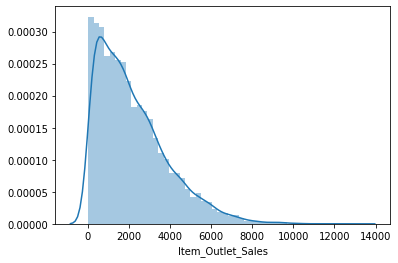

In [22]:
sns.distplot(data['Item_Outlet_Sales'].dropna())

# Lets Perform Univariate Analysis

In [23]:
# Univariate Categorical columns plots

    # makeUnivariateCategoricalplotBARV(catColList, dataFrame):
    # makeUnivariateCategoricaPlotPIE(catColList, dataFrame):
    #crossTabHistGramPlotSplit(CatColList, BinaryValColumn, Dataframe):
    #Bivariate_ContiList_over_CataList_mean_CheckOrdinality(ContiList, CatList,DataFrame)
    #crossTabHistGramPlot(CatColList, BinaryValColumn, Dataframe)

cat_cols=[str(i) for i in cat_cols]
cat_cols=cat_cols[1:]

desc(data[cat_cols])

dtypes  null_count  total_count  unique_count  \
Outlet_Location_Type       object         0.0      14204.0           3.0   
Outlet_Size                object         0.0      14204.0           3.0   
Outlet_Type                object         0.0      14204.0           4.0   
Item_Fat_Content           object         0.0      14204.0           5.0   
Outlet_Establishment_Year   int64         0.0      14204.0           9.0   
Item_Type                  object         0.0      14204.0          16.0   

                          missing value ratio variance of numerics      std  \
Outlet_Location_Type                       0%                  NaN      NaN   
Outlet_Size                                0%                  NaN      NaN   
Outlet_Type                                0%                  NaN      NaN   
Item_Fat_Content                           0%                  NaN      NaN   
Outlet_Establishment_Year                  0%              70.0848  8.37166   
Item_Type                                  0%                  NaN      NaN   

                           mean   min  
Outlet_Location_Type        NaN   NaN  
Outlet_Size                 NaN   NaN  
Outlet_Type                 NaN   NaN  
Item_Fat_Content            NaN   NaN  
Outlet_Establishment_Year  2009  1985  
Item_Type                   NaN   NaN

In [24]:
# Action 3 New Feature Created
data['Item_Category'] = data['Item_Identifier'].apply(lambda x: x[0:2]).map({'FD':'Food',
                                                              'NC':'Non-Consumable',
                                                              'DR':'Drinks'})
data['Item_Category'].value_counts()
cat_nominal_cols = cat_nominal_cols + ['Item_Category']
cat_cols = cat_cols  + ['Item_Category']

In [25]:
data['Outlet_Establishment_Year']=(data['Outlet_Establishment_Year'] - data['Outlet_Establishment_Year'].min())

In [26]:
data['Outlet_Establishment_Year'].value_counts()

0     2439
2     1553
14    1550
12    1550
19    1550
17    1548
24    1546
22    1543
13     925
Name: Outlet_Establishment_Year, dtype: int64

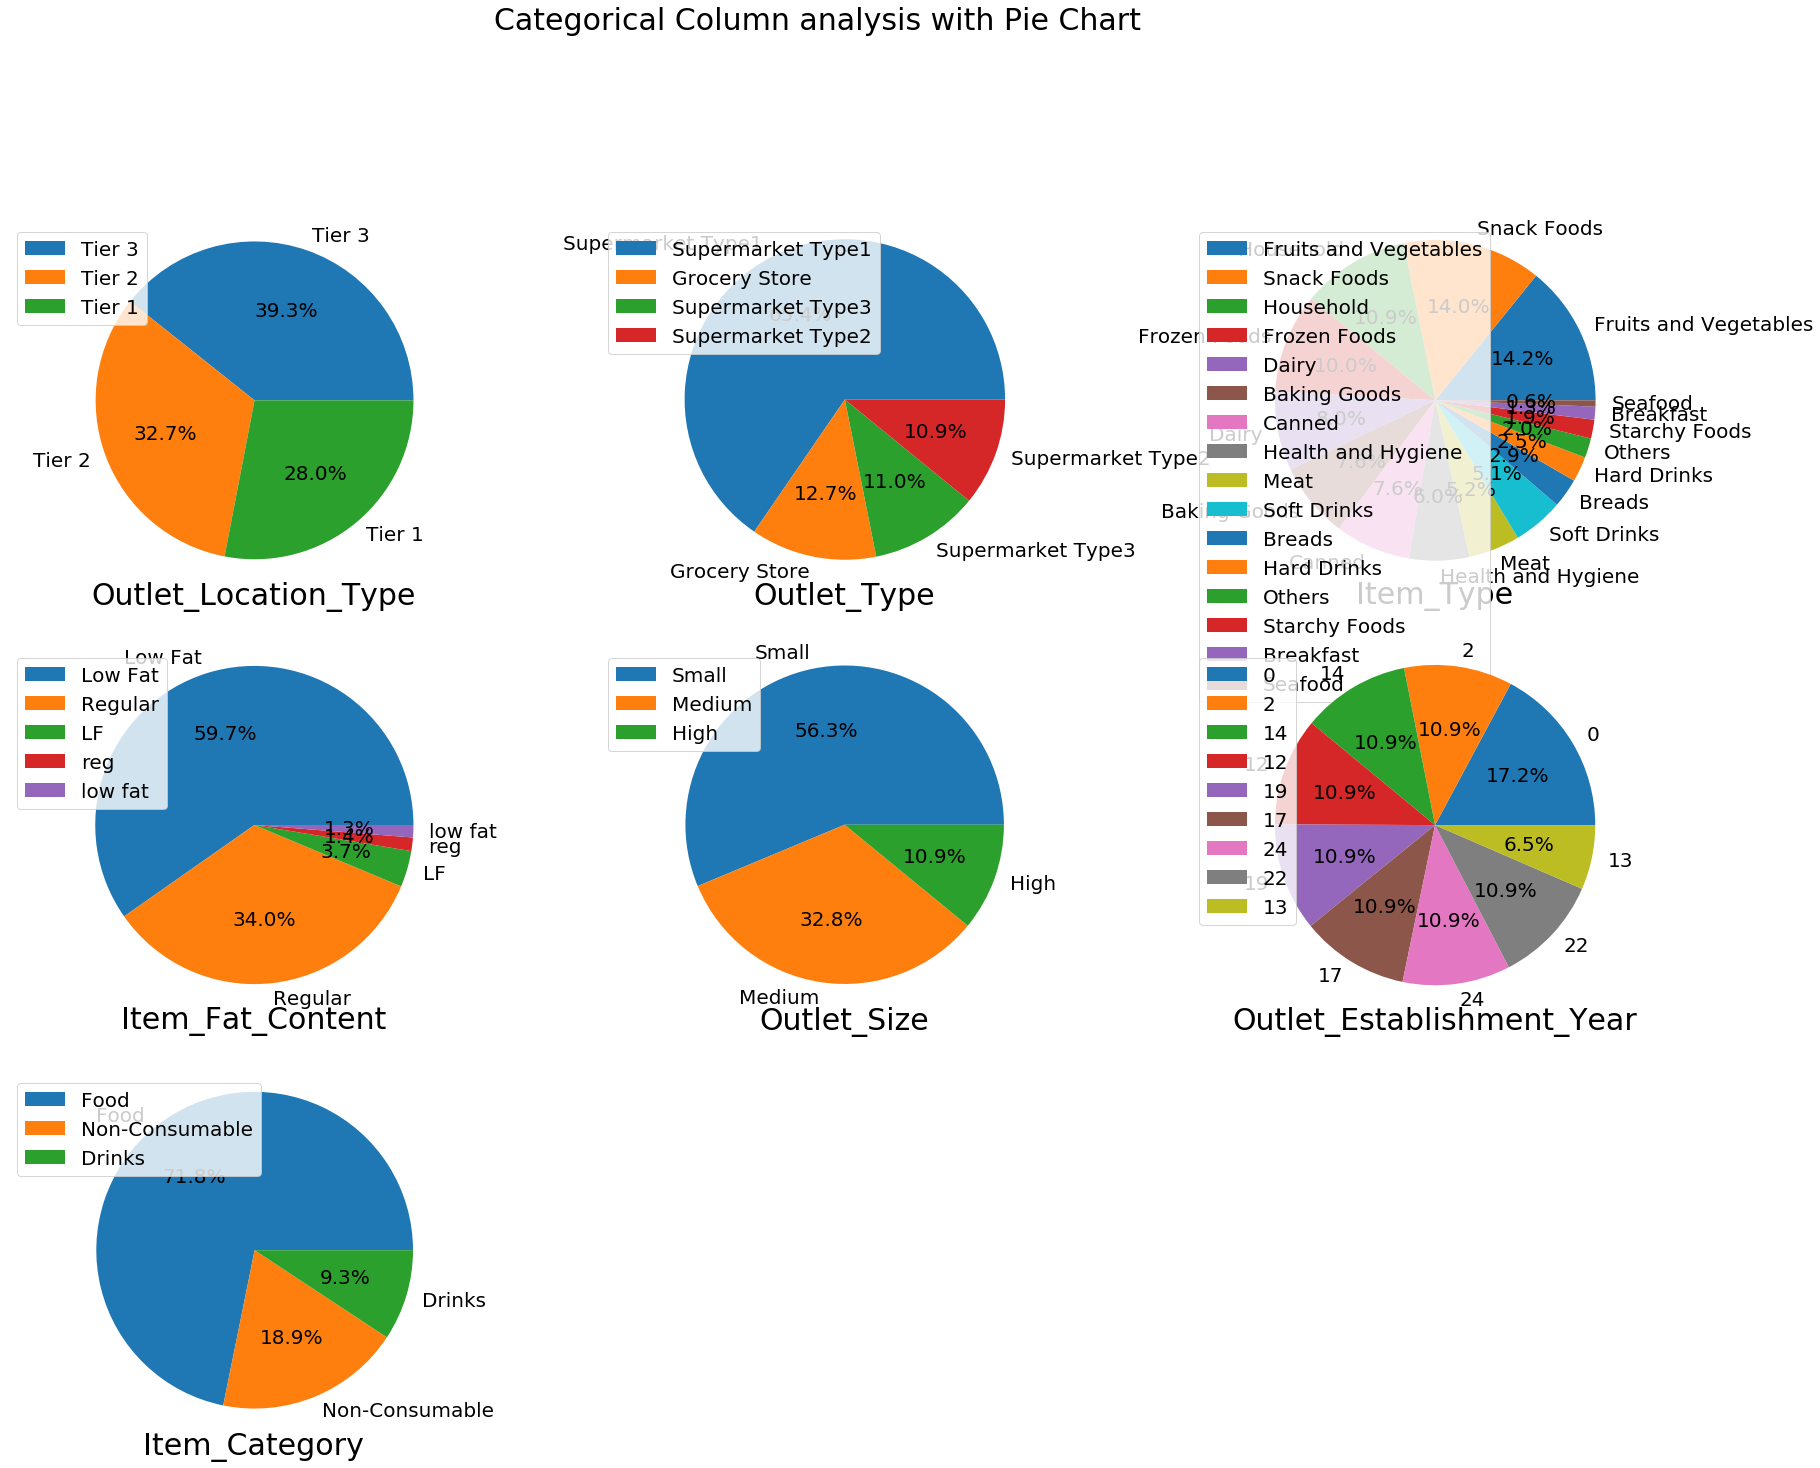

In [27]:
makeUnivariateCategoricaPlotPIE(cat_cols,data)

# Feature transformation (categorical Vars)
### 1. should be done based on input taken from univariate analysis on categorical columns 
#### Note:  Feature Transformation is one of the Feature Engineering technique

In [28]:
# 
#  1) Item Fat content Categories are mis-spelled
#  2) the Item Type , there are many different categories, So it need to merged somehow
#  3) Super market2 and super market 3 can be merged in Outlet type, As sub categrory are not distributed properly.

# We use
# print '\nModified Categories:'
# data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
#                                                             'reg':'Regular',
#                                                             'low fat':'Low Fat'})

In [29]:
#1) ACTION 1 -  Item Fat content Categories are mis-spelled
data['Item_Fat_Content'][data['Item_Fat_Content'].isin(['Low Fat','LF','low fat'])] ='LF'
data['Item_Fat_Content'][data['Item_Fat_Content'].isin(['reg'])] ='Regular'

/Users/keeratjohar2305/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/keeratjohar2305/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


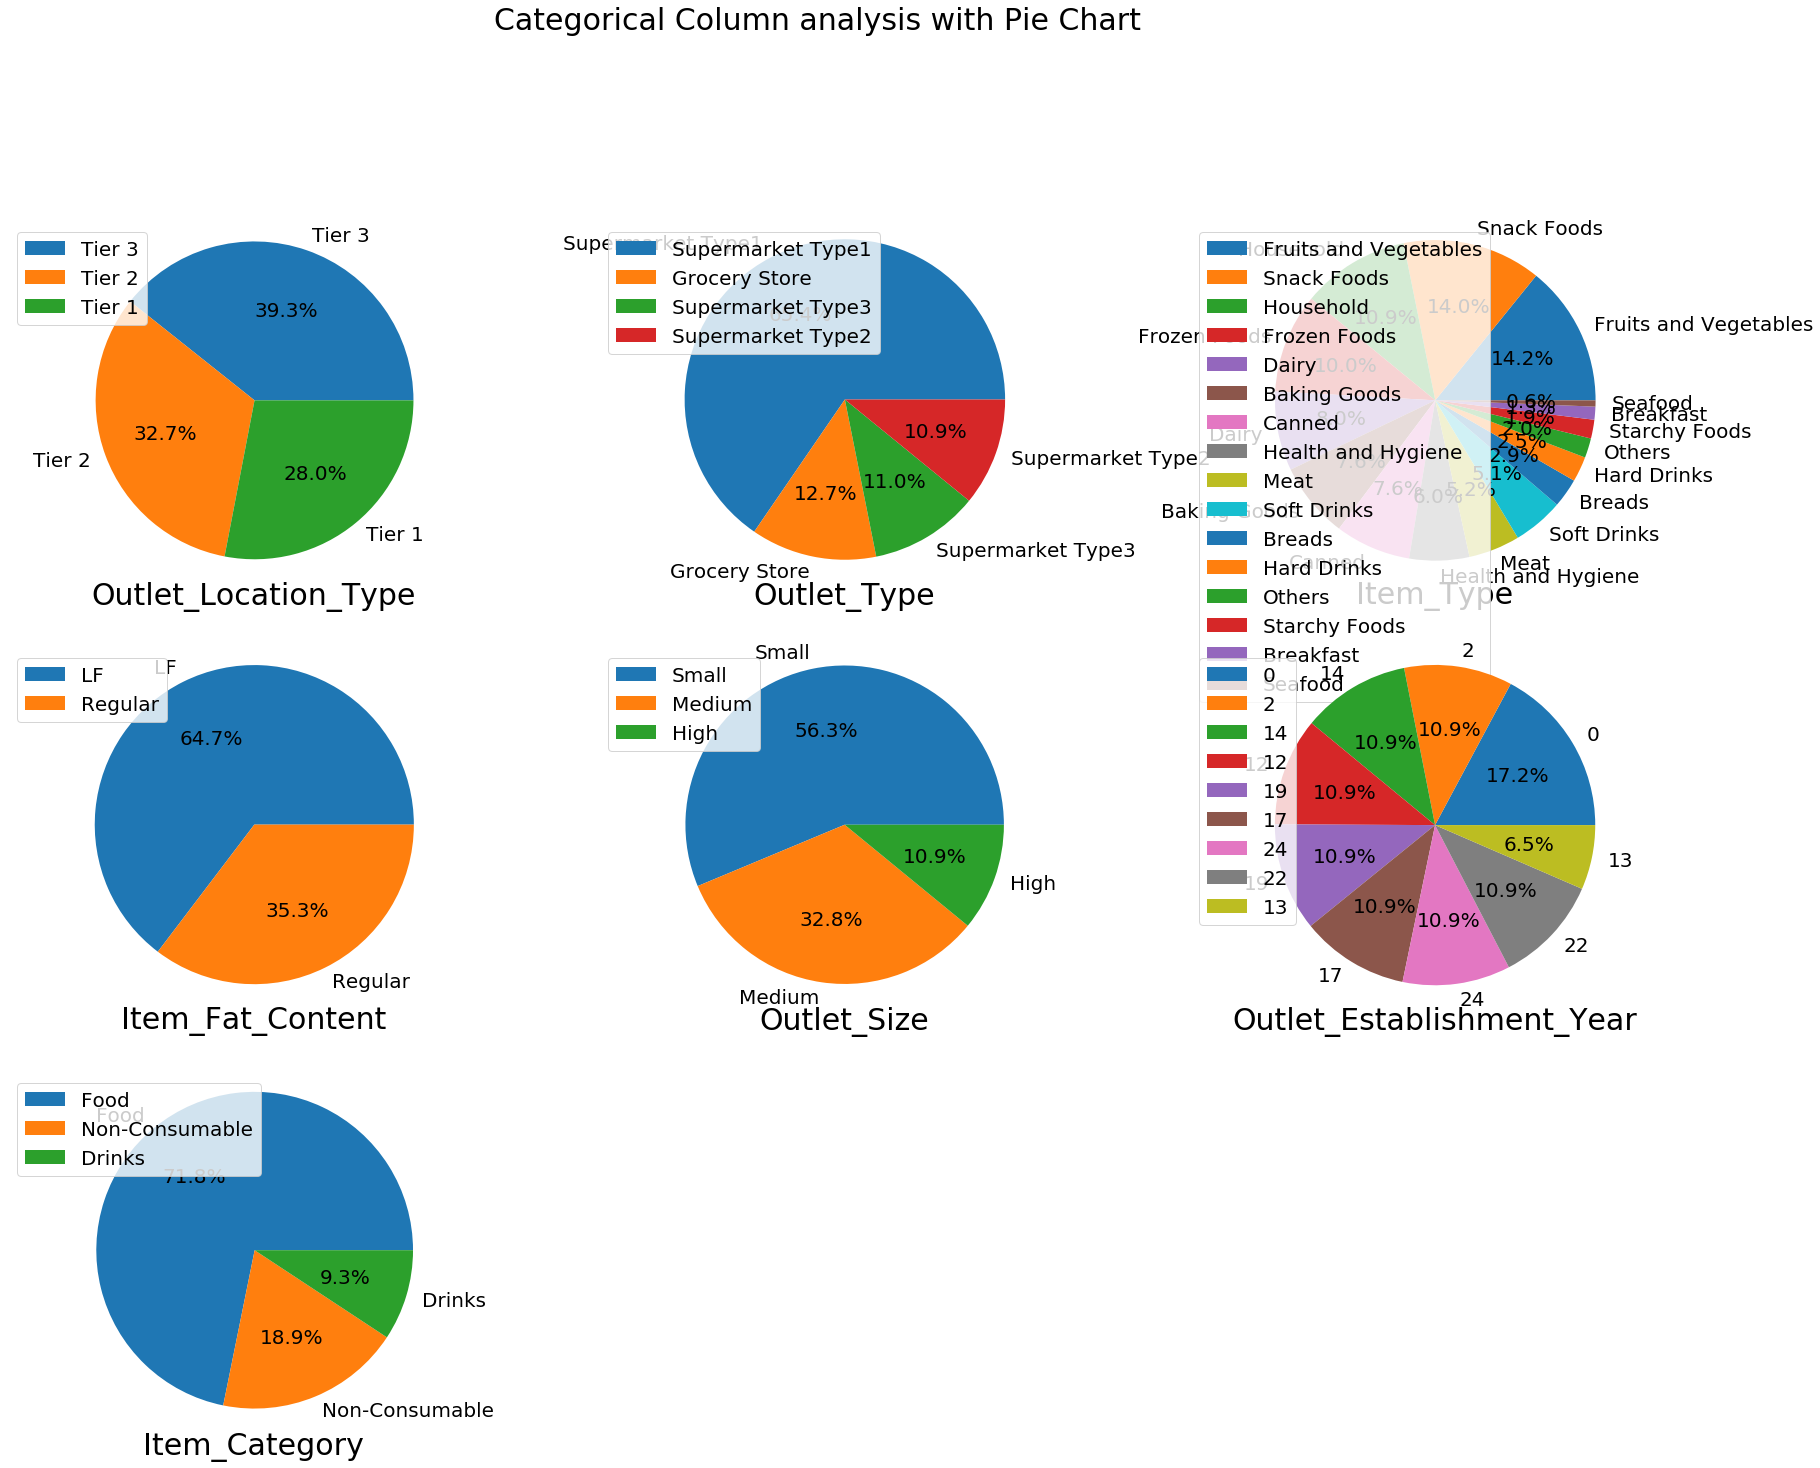

In [30]:
makeUnivariateCategoricaPlotPIE(cat_cols,data)

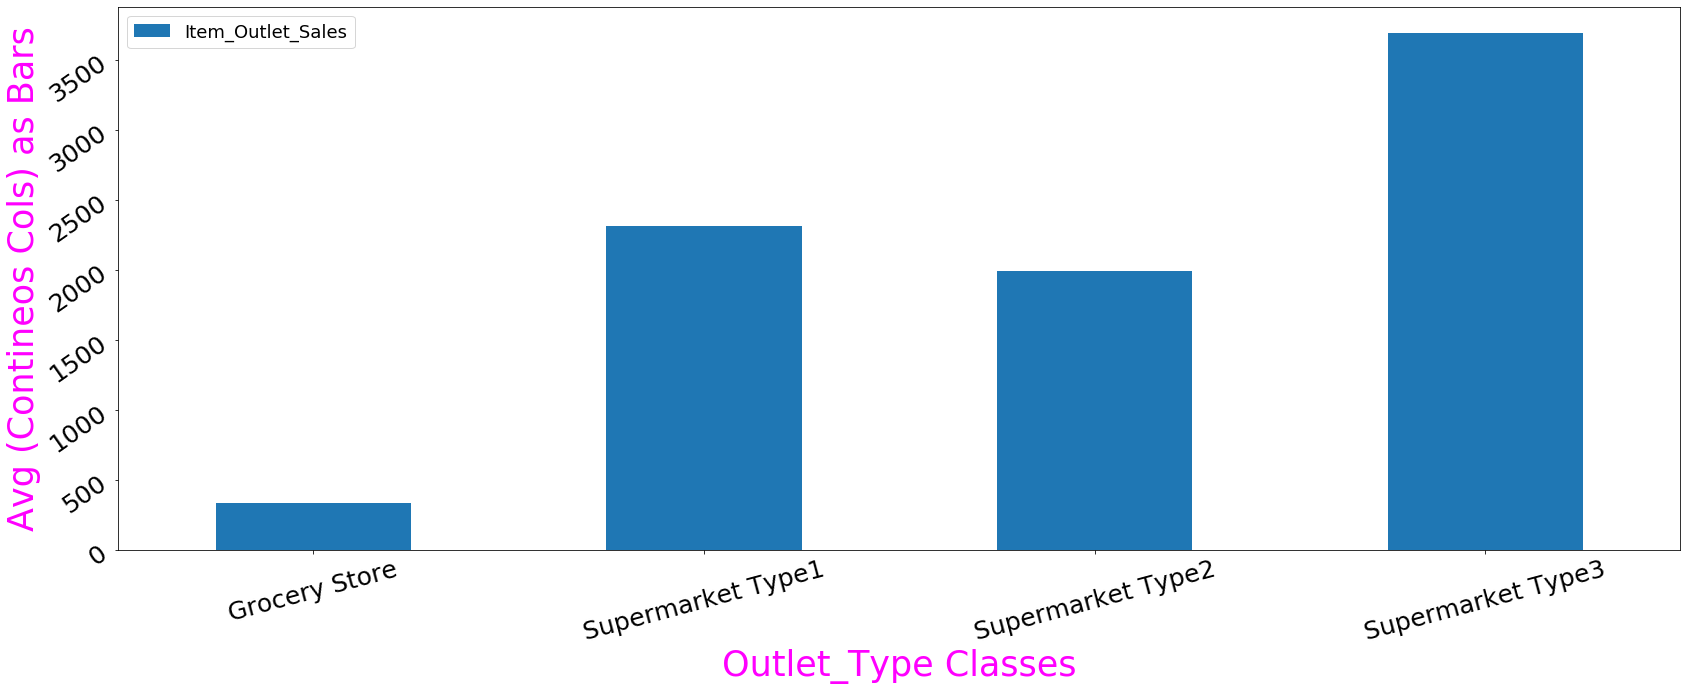

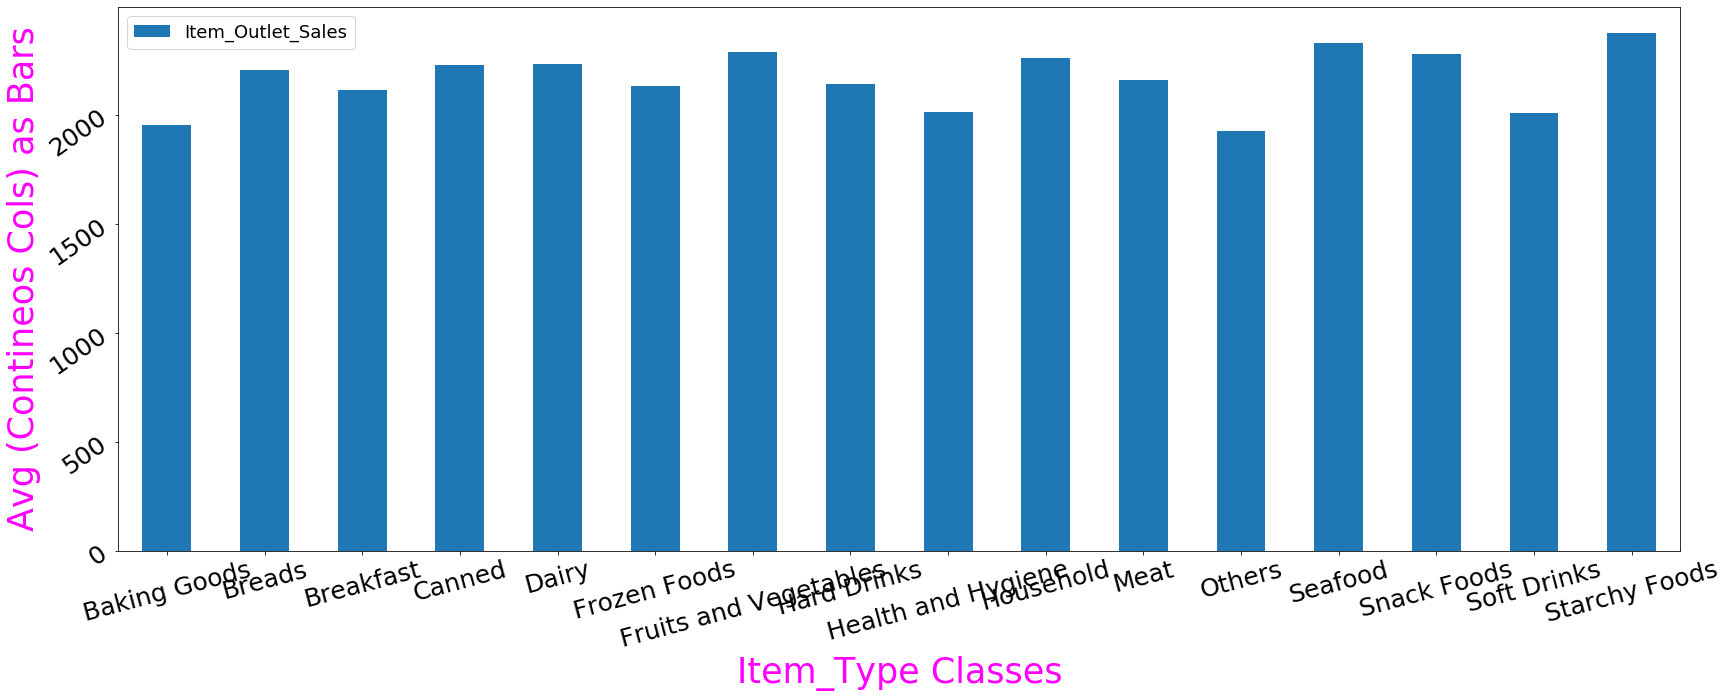

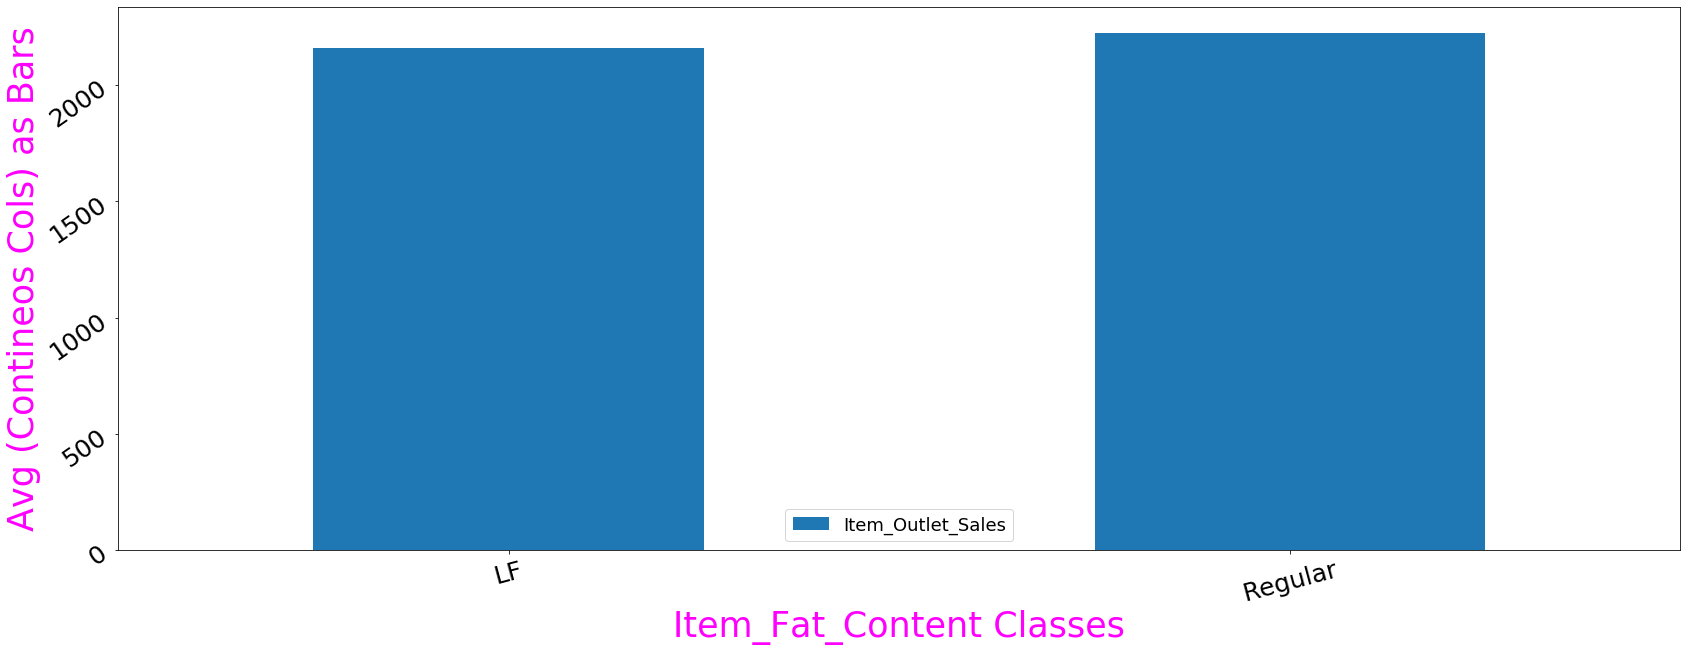

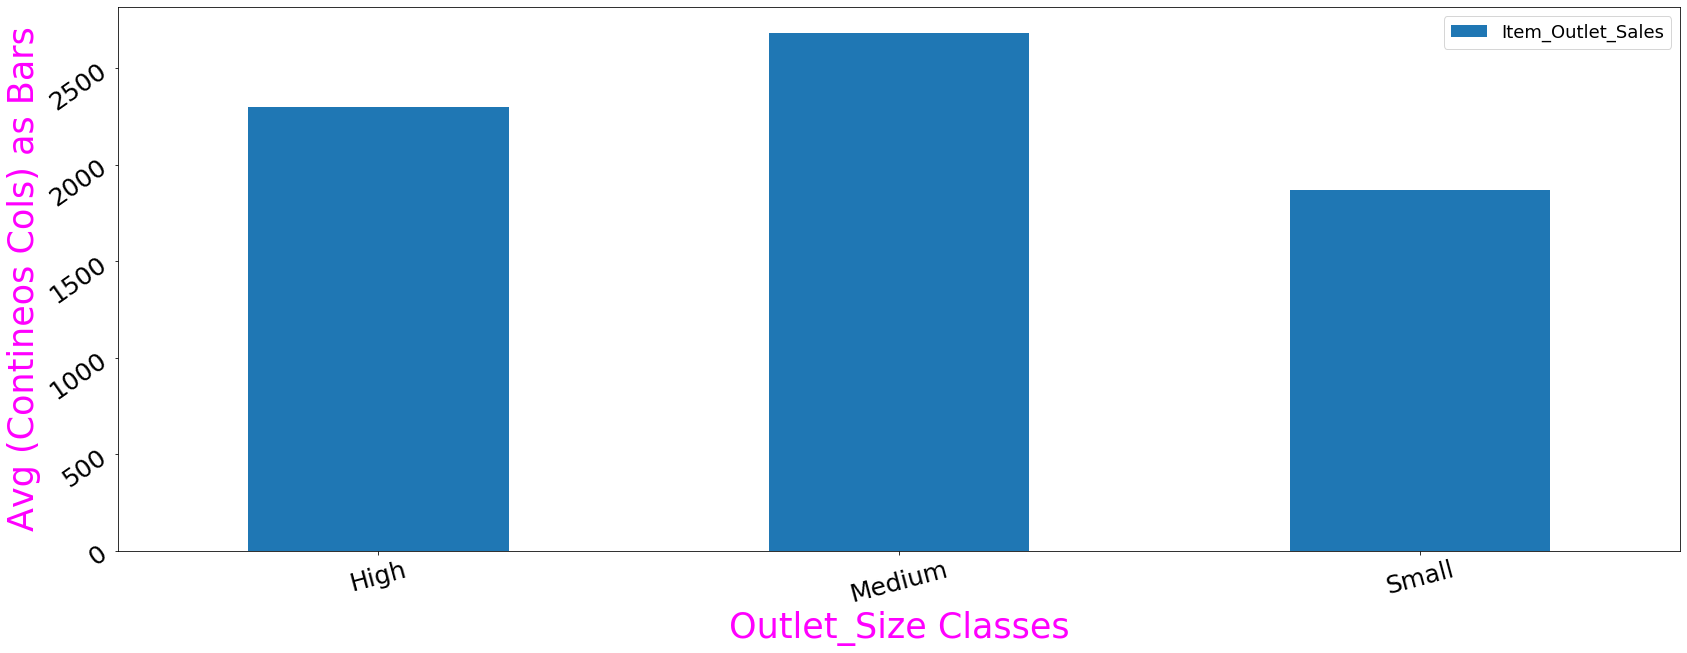

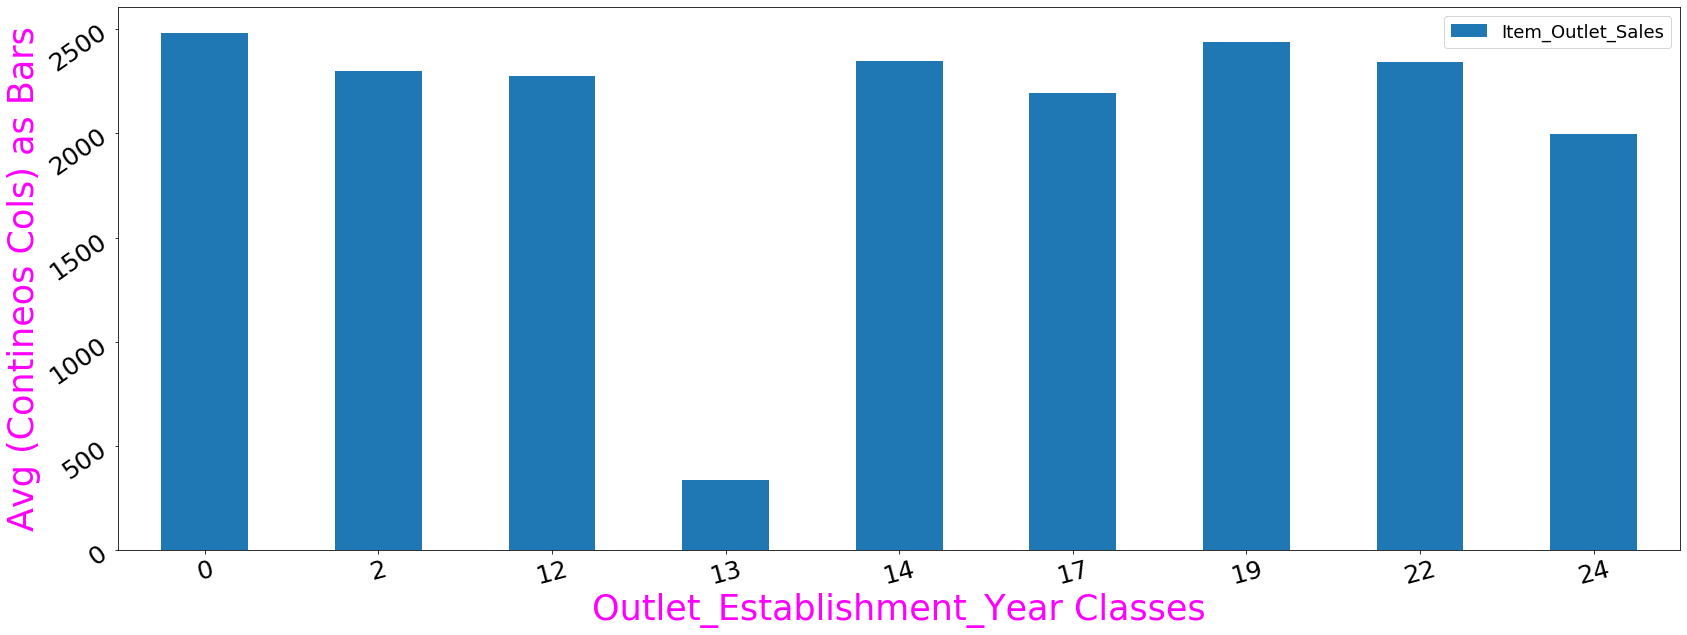

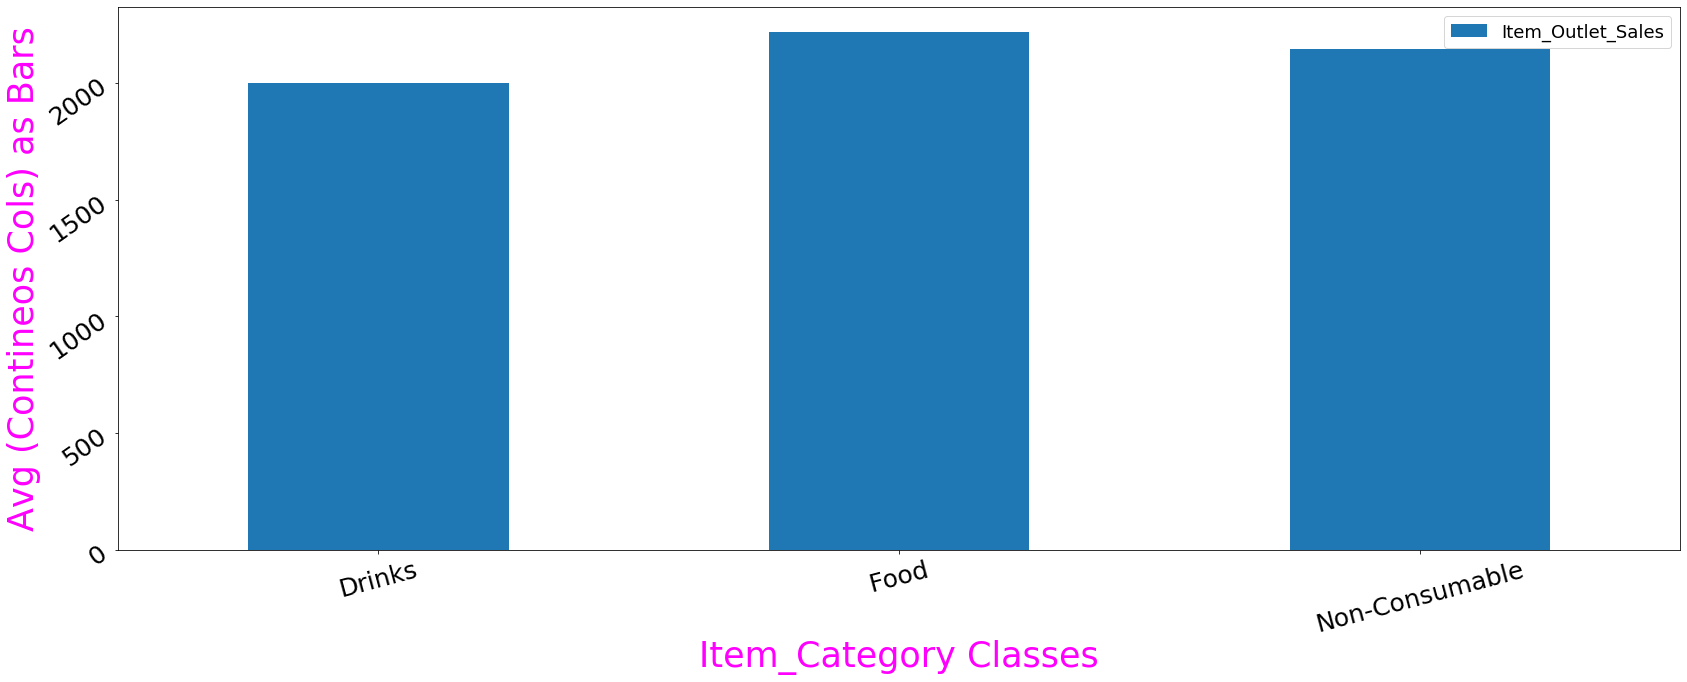

In [31]:
#Bivariate_ContiList_over_CataList_mean_CheckOrdinality(ContiList, CatList,train)
Bivariate_ContiList_over_CataList_mean_CheckOrdinality(['Item_Outlet_Sales'], cat_cols[1:],train)

In [32]:
#  2) the Item Type , there are many different categories, So it need to merged somehow
# # But is that a good idea? A quick way to check that could be to analyze the mean sales by type of store. 
# If they have similar sales, then keeping them separate won’t help much.
train.pivot_table('Item_Outlet_Sales',index=['Item_Type'])

#See the average sale is same, we can merge them But lets not do this as AV tutorial doing anything on it.


Item_Outlet_Sales
Item_Type                               
Baking Goods                 1952.971207
Breads                       2204.132226
Breakfast                    2111.808651
Canned                       2225.194904
Dairy                        2232.542597
Frozen Foods                 2132.867744
Fruits and Vegetables        2289.009592
Hard Drinks                  2139.221622
Health and Hygiene           2010.000265
Household                    2258.784300
Meat                         2158.977911
Others                       1926.139702
Seafood                      2326.065928
Snack Foods                  2277.321739
Soft Drinks                  2006.511735
Starchy Foods                2374.332773

In [33]:
#  3) Super market2 and super market 3 can be merged in Outlet type, As sub categrory are not distributed properly.
#During exploration, we decided to consider combining the Supermarket Type2 and Type3 variables. 
# But is that a good idea? A quick way to check that could be to analyze the mean sales by type of store. 
# If they have similar sales, then keeping them separate won’t help much.


train.pivot_table('Item_Outlet_Sales',index=['Outlet_Type'])

# Observer
# This shows significant difference between them and we’ll leave them as it is. Note that this is just one way 
# of doing this, you can perform some other analysis in different situations and also do the same for other features


Item_Outlet_Sales
Outlet_Type                         
Grocery Store             339.828500
Supermarket Type1        2316.181148
Supermarket Type2        1995.498739
Supermarket Type3        3694.038558

# Univarite Analysis for Contineous Variable
 Univaricate Contineous columns plots

     Univariate_conti_var_Histogram(catColList, dataFrame)
     Univariate_conti_var_Box(catColList, dataFrame):
     SNS_BoxSubplots_univaricate_Contineous(conti_col,df):
     SNS_dist_subplots_univaricate_Contineous(conti_col,df):

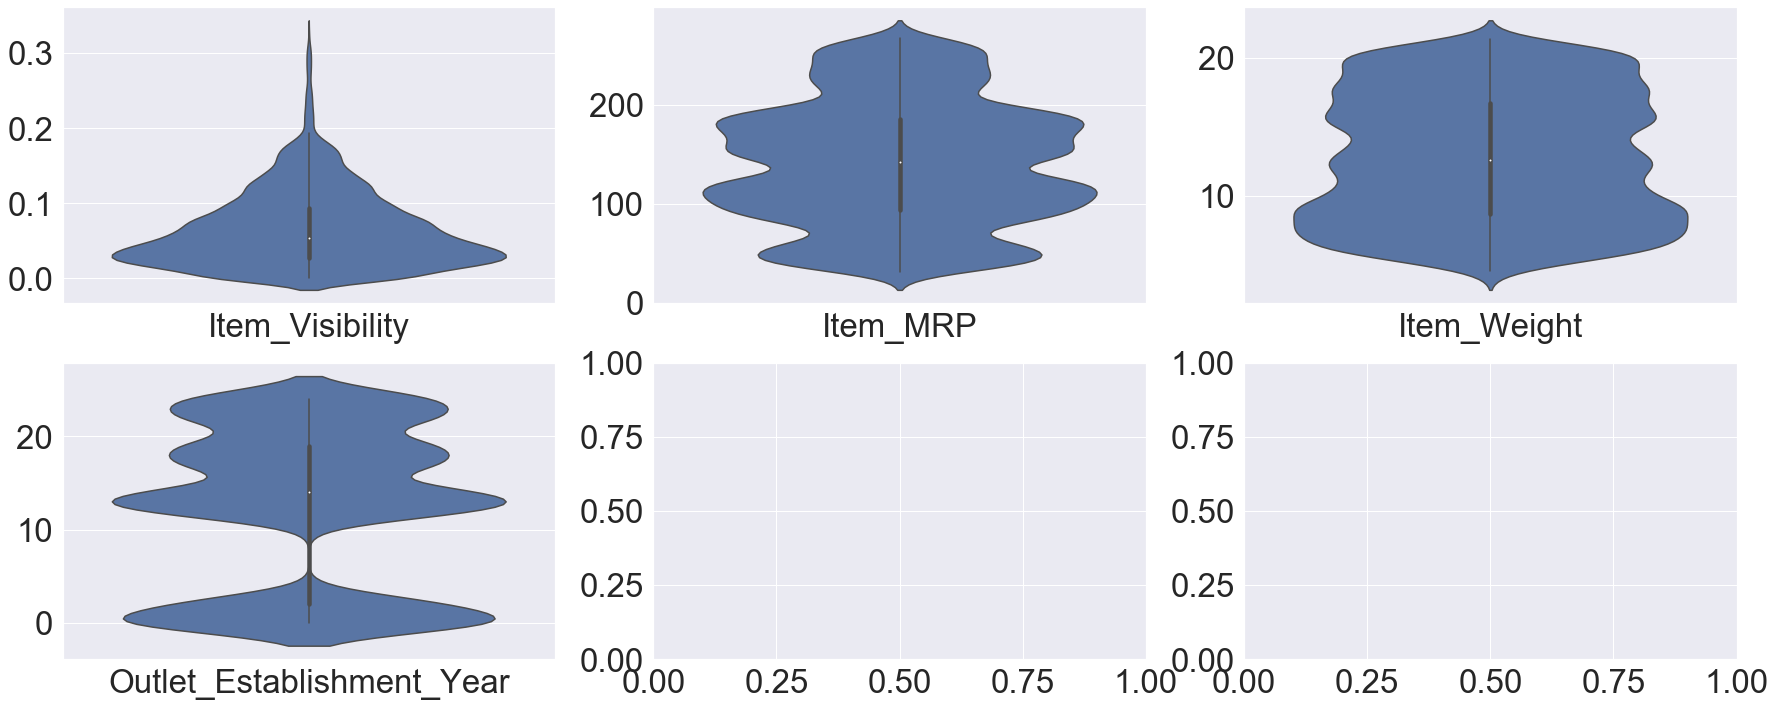

In [34]:
SNS_BoxSubplots_univaricate_Contineous(conti_cols[1:]+['Outlet_Establishment_Year'],data)

 Lets create Vertical Multi HISTOGRAM plot for column 
['Item_Visibility', 'Item_MRP', 'Item_Weight', 'Outlet_Establishment_Year']


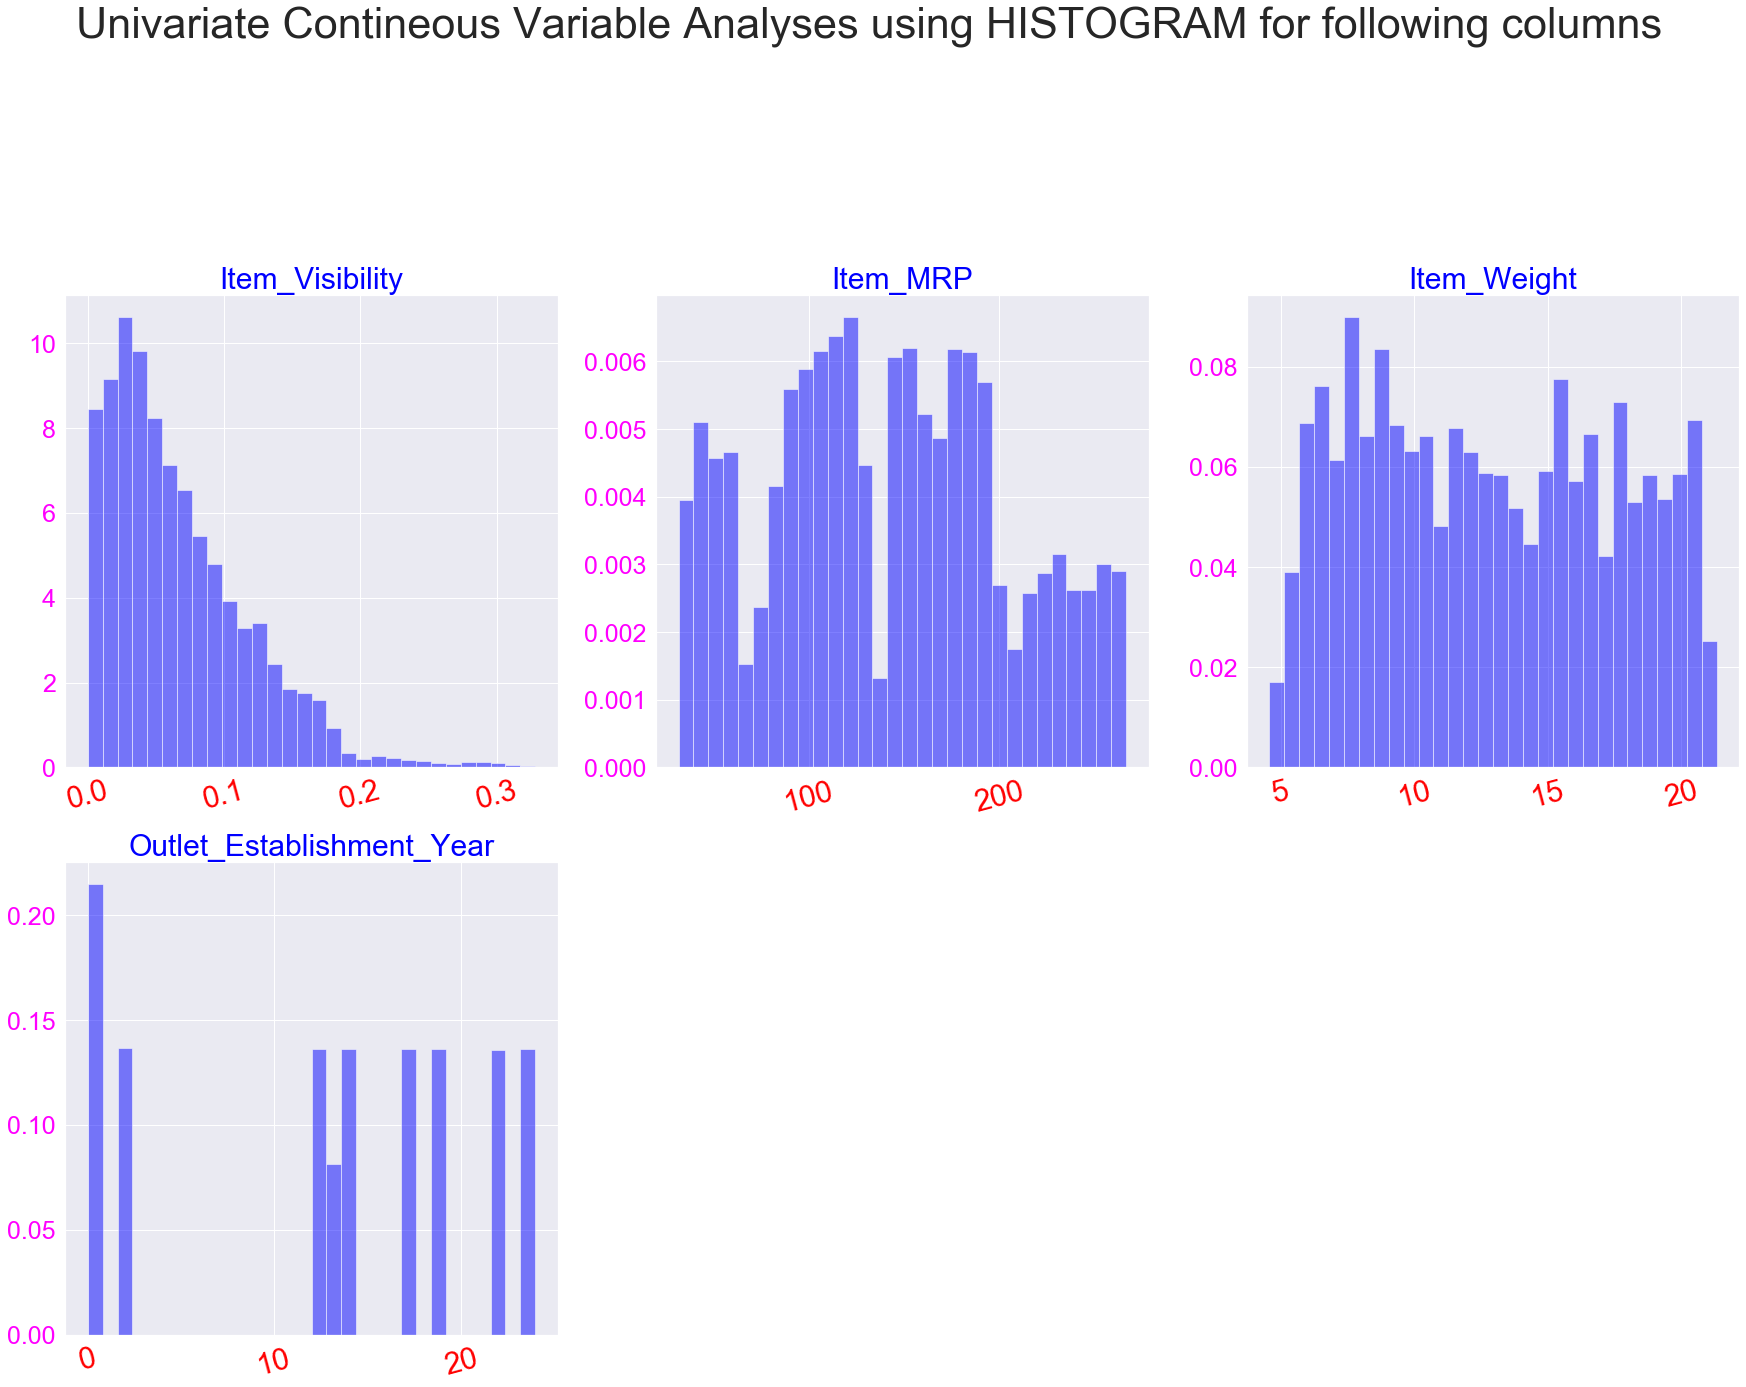

In [35]:
Univariate_conti_var_Histogram(conti_cols[1:]+['Outlet_Establishment_Year'],data)


 Lets create Vertical Multi HISTOGRAM plot for column 
['Item_Visibility', 'Item_MRP', 'Item_Weight']


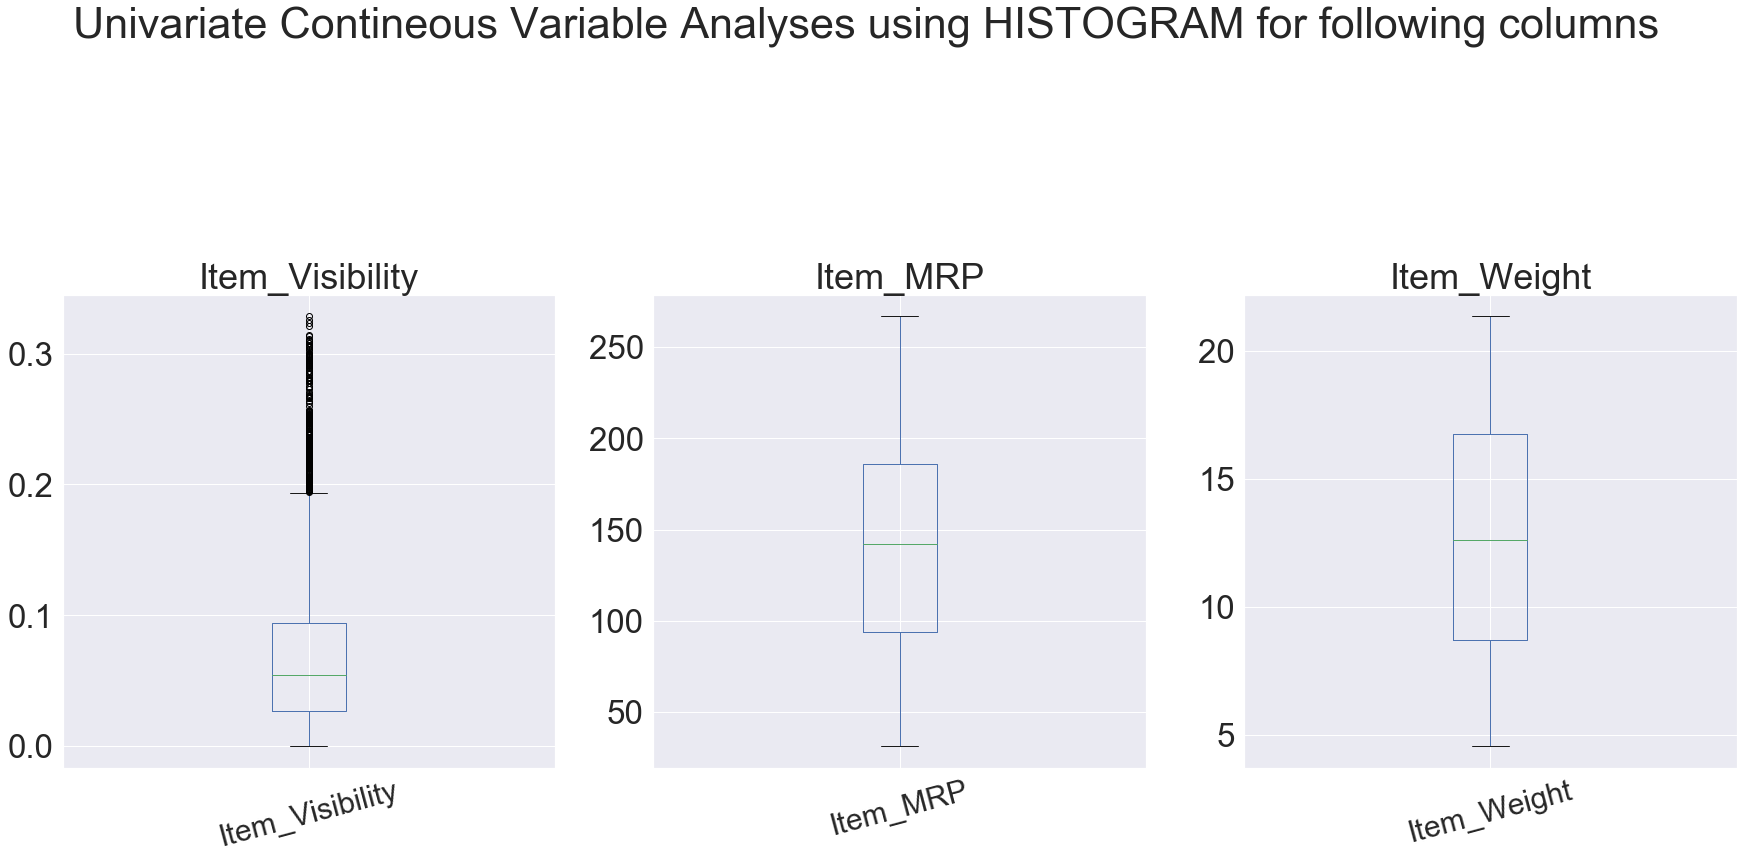

In [36]:
Univariate_conti_var_Box(conti_cols[1:],data)

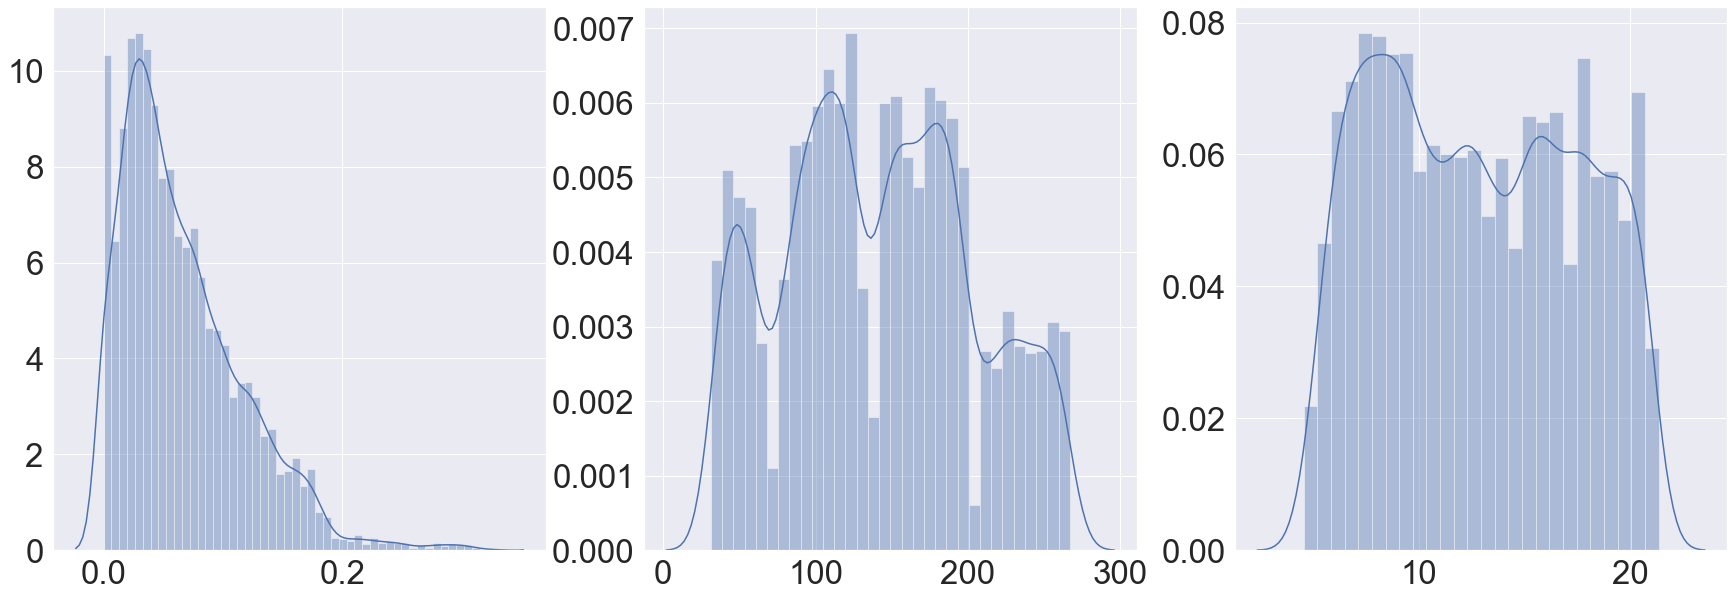

In [37]:
SNS_dist_subplots_univaricate_Contineous(conti_cols[1:],data)

In [38]:
# Observation of Univariate Analysis are
# Item_visibility are right skewed ( lot of outliers) options are nth root or log
# Item_Weight is not  skewed
# Item_MRP is not skewed

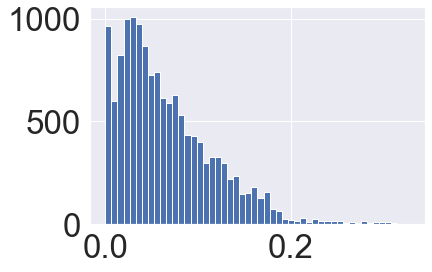

In [39]:
data.Item_Visibility.hist(bins=50)

In [40]:
# Observation of Univariate Analysis are
# Item_visibility are right skewed ( lot of outliers) options are nth root or log

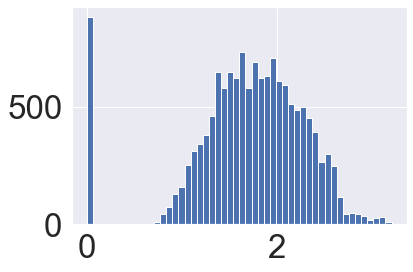

In [41]:
np.power(data.Item_Visibility*100,1/3).hist(bins=50)  
# Addressed using cube root

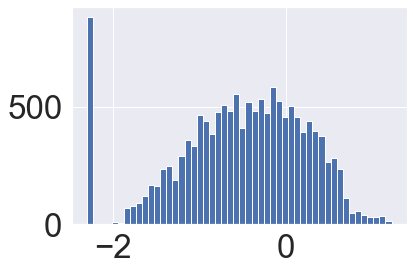

In [42]:
np.log(data.Item_Visibility*10 + 0.1).hist(bins=50)  
# Observe the data is not perfectly become symmetterical after apply log
# Note: 0.1 is added because we have zero observation in this feature , adding constant will change any distribution


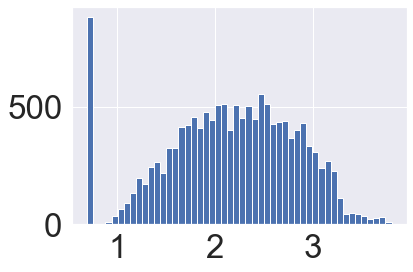

In [43]:
# Let multiple feature by 100 to change the scale
np.log(data.Item_Visibility*130+2).hist(bins=50) 

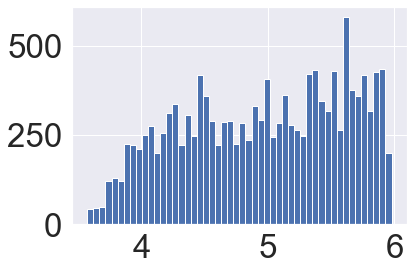

In [44]:
np.power(data.Item_Weight*10,1/3).hist(bins=50)

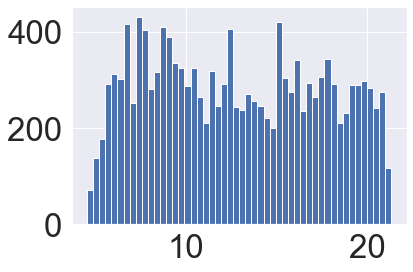

In [45]:
data.Item_Weight.hist(bins=50)

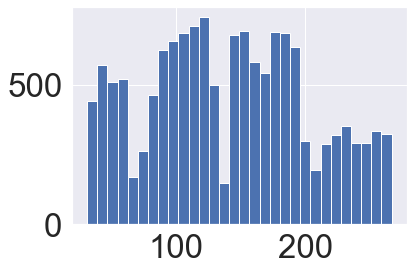

In [46]:
data.Item_MRP.hist(bins=30)

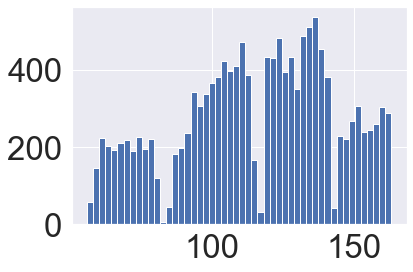

In [47]:
np.power(data.Item_MRP*100,1/2).hist(bins=50)

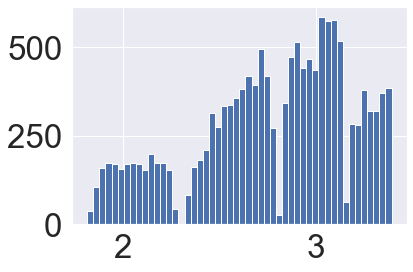

In [48]:
np.log(data.Item_MRP*0.1+3).hist(bins=50)

# Feature transformation  on  Contineous Variable
#### 1.       Should be done after performing Univariate Analysis on  Contineous Variable
#### Note:  Feature Transformation is one of the Feature Engineering technique

In [49]:
# Action 1  on Item_Visibility
# We noticed that the minimum value here is 0, which makes no practical sense. 
# Lets consider it like missing information and impute it with mean visibility of that product.
# Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.Item_Visibility[x])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))
conti_num_cols

Number of 0 values initially: 879
Number of 0 values after modification: 0


['Item_Visibility', 'Item_MRP', 'Item_Weight']

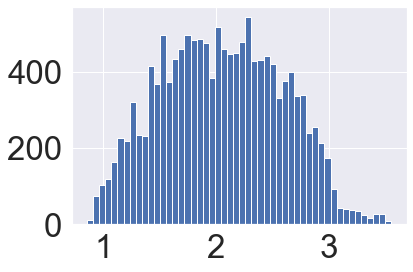

In [50]:
np.log(data.Item_Visibility*100+2).hist(bins=50) 

In [51]:
#So, let replace the feature with log value
data['Item_Visibility']=np.log(data.Item_Visibility*100+2)

In [52]:
visibility_avg

Item_Visibility
Item_Identifier                 
DRA12                   0.034938
DRA24                   0.045646
DRA59                   0.133384
DRB01                   0.079736
DRB13                   0.006799
DRB24                   0.020596
DRB25                   0.079407
DRB48                   0.023973
DRC01                   0.020653
DRC12                   0.037862
DRC13                   0.028408
DRC24                   0.026913
DRC25                   0.047354
DRC27                   0.066423
DRC36                   0.046932
DRC49                   0.070950
DRD01                   0.066330
DRD12                   0.074150
DRD13                   0.049125
DRD15                   0.064930
DRD24                   0.035205
DRD25                   0.082385
DRD27                   0.020545
DRD37                   0.013352
DRD49                   0.167987
DRD60                   0.040369
DRE01                   0.179808
DRE03                   0.026061
DRE12                   0.061981
DRE13                   0.031673
...                          ...
NCX05                   0.110962
NCX06                   0.017934
NCX17                   0.113709
NCX18                   0.008293
NCX29                   0.101920
NCX30                   0.025977
NCX41                   0.017291
NCX42                   0.006482
NCX53                   0.014409
NCX54                   0.051698
NCY05                   0.059645
NCY06                   0.065816
NCY17                   0.126951
NCY18                   0.033510
NCY29                   0.088295
NCY30                   0.028140
NCY41                   0.086582
NCY42                   0.016440
NCY53                   0.056916
NCY54                   0.191145
NCZ05                   0.063030
NCZ06                   0.102096
NCZ17                   0.076568
NCZ18                   0.180954
NCZ29                   0.076774
NCZ30                   0.027302
NCZ41                   0.056396
NCZ42                   0.011015
NCZ53                   0.026330
NCZ54                   0.081345

[1559 rows x 1 columns]

In [53]:
# Action 2 on New feature (Item_Visibility) created
#data['Item_Visibility_MeanRatio']=data.apply(lambda x: x['Item_Visibility']/visibility_avg.Item_Visibility[x['Item_Identifier']], axis=1)
#Univariate_conti_var_Histogram(conti_cols,data)
#cat_cols = cat_cols + ['Item_Visibility_MeanRatio']
#makeUnivariateCategoricaPlotPIE(cat_cols,data)
#data['Item_Visibility_MeanRatio'].values_count()

# Bivariate Analysis 
### Independent categorical columns vs target contineous variable

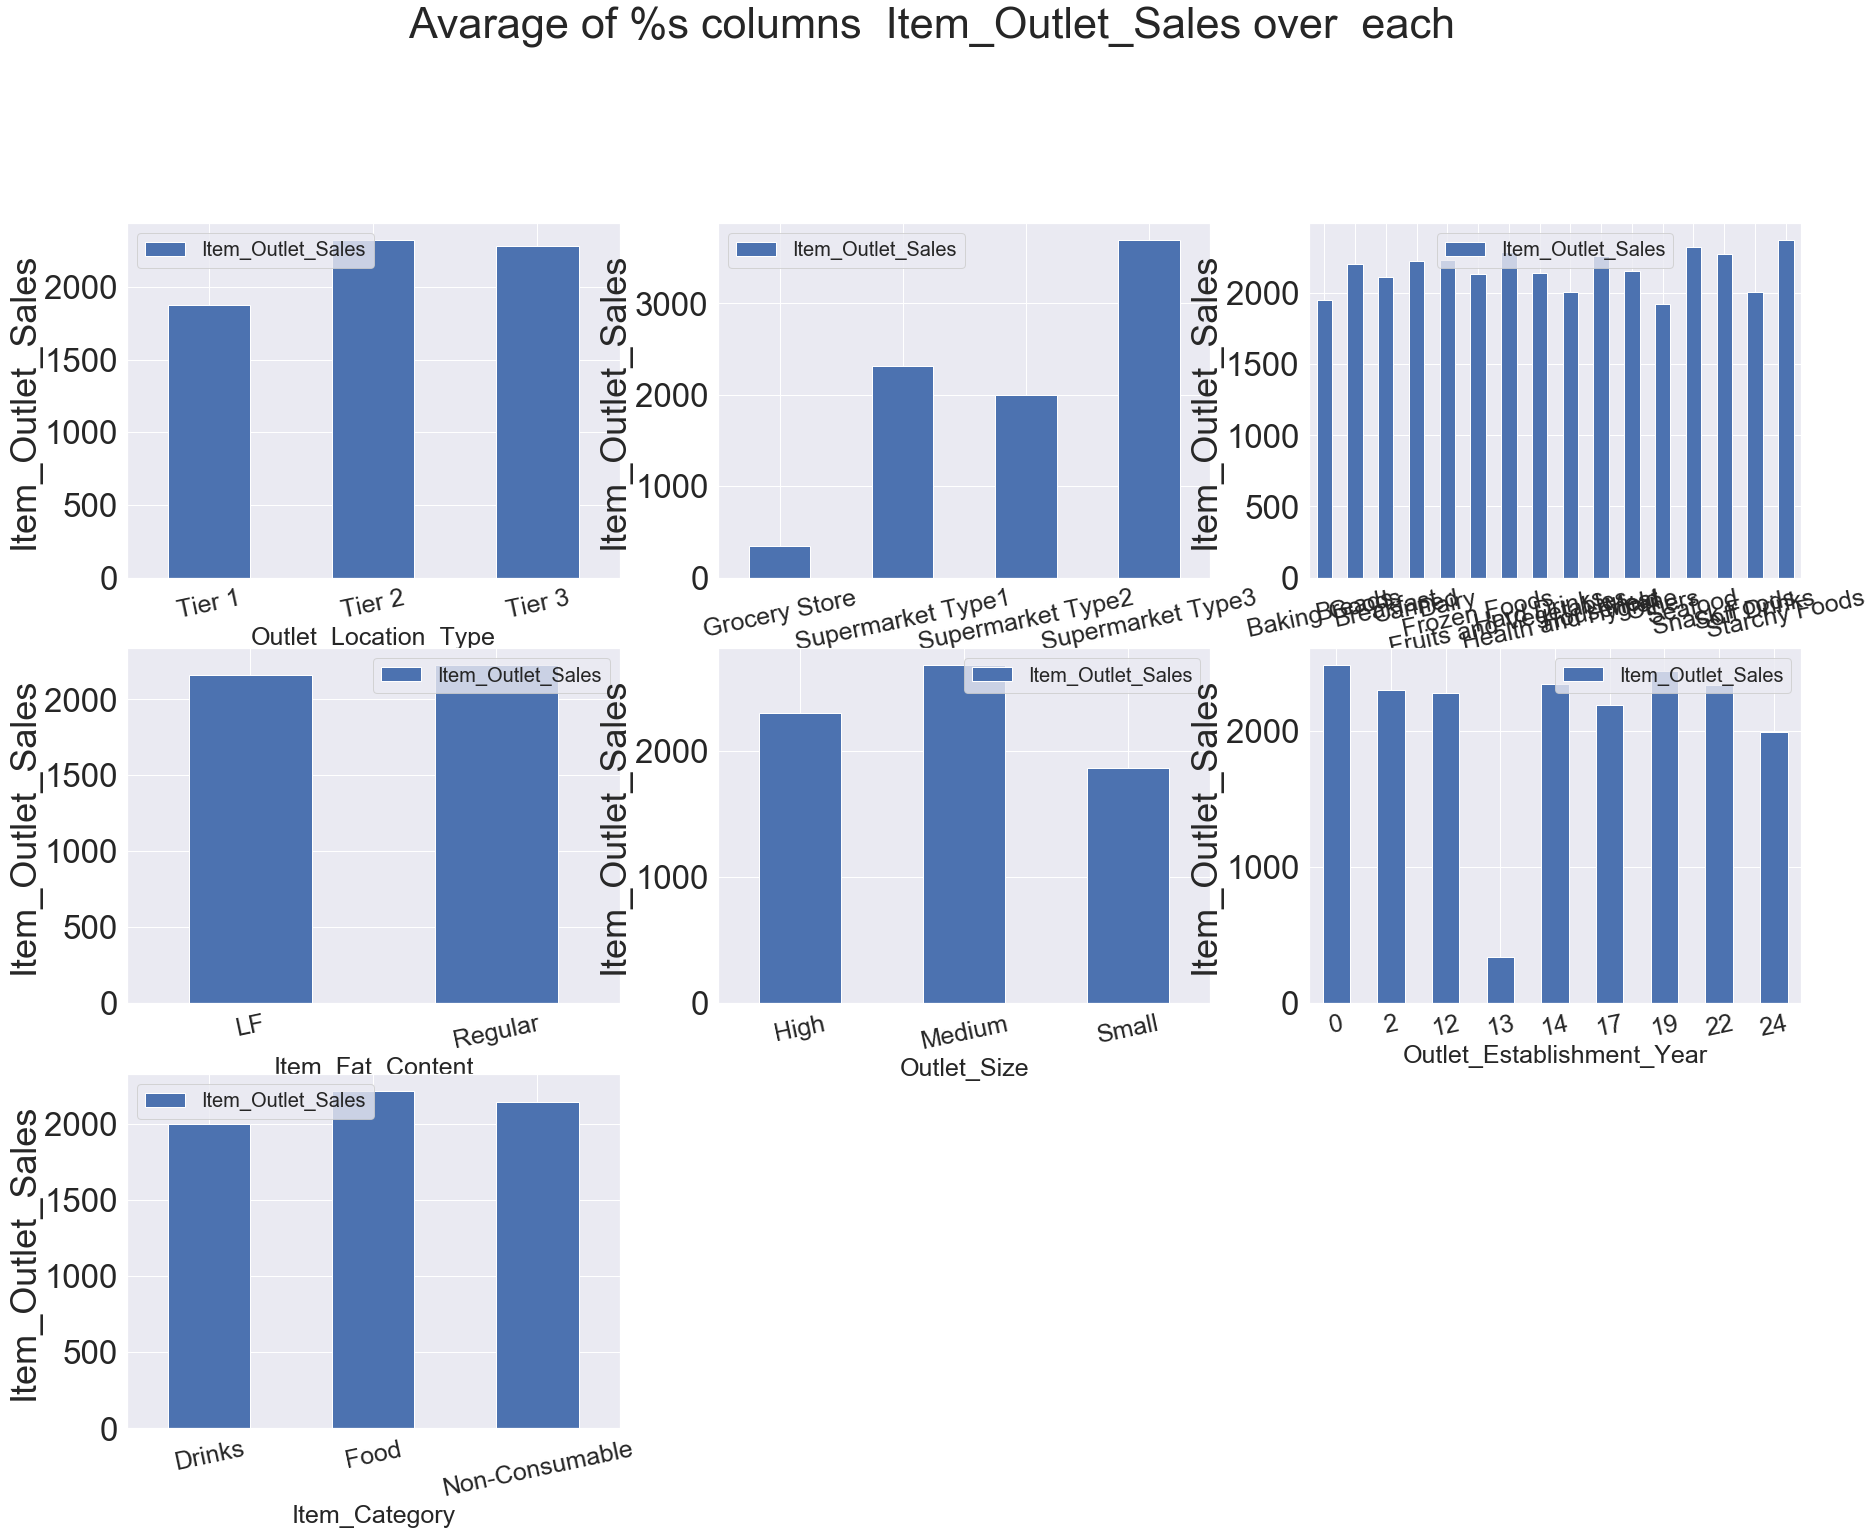

In [54]:
Bivariate_Ana_Catogorical_over_ContiLabel_Pivotmean(cat_cols,'Item_Outlet_Sales',data)
#cat_nominal_cols

# Correlation with Label Column
### We should all the contineous columns which are correlated with label

In [55]:
data[['Item_Weight','Item_MRP',label_col,'Item_Visibility']].corr()

Item_Weight  Item_MRP  Item_Outlet_Sales  Item_Visibility
Item_Weight           1.000000  0.035751           0.013261        -0.022345
Item_MRP              0.035751  1.000000           0.567574        -0.001095
Item_Outlet_Sales     0.013261  0.567574           1.000000        -0.102051
Item_Visibility      -0.022345 -0.001095          -0.102051         1.000000

                           Item_MRP  Item_Outlet_Sales  Item_Visibility  \
Item_MRP                        NaN           0.567574         0.001095   
Item_Outlet_Sales               NaN                NaN         0.102051   
Item_Visibility                 NaN                NaN              NaN   
Item_Weight                     NaN                NaN              NaN   
Outlet_Establishment_Year       NaN                NaN              NaN   

                           Item_Weight  Outlet_Establishment_Year  
Item_MRP                      0.035751                   0.000141  
Item_Outlet_Sales             0.013261                   0.049135  
Item_Visibility               0.022345                   0.066681  
Item_Weight                        NaN                   0.000247  
Outlet_Establishment_Year          NaN                        NaN  


Drop following highly correlated column Crossing the threashold values(0.6):
                                                []




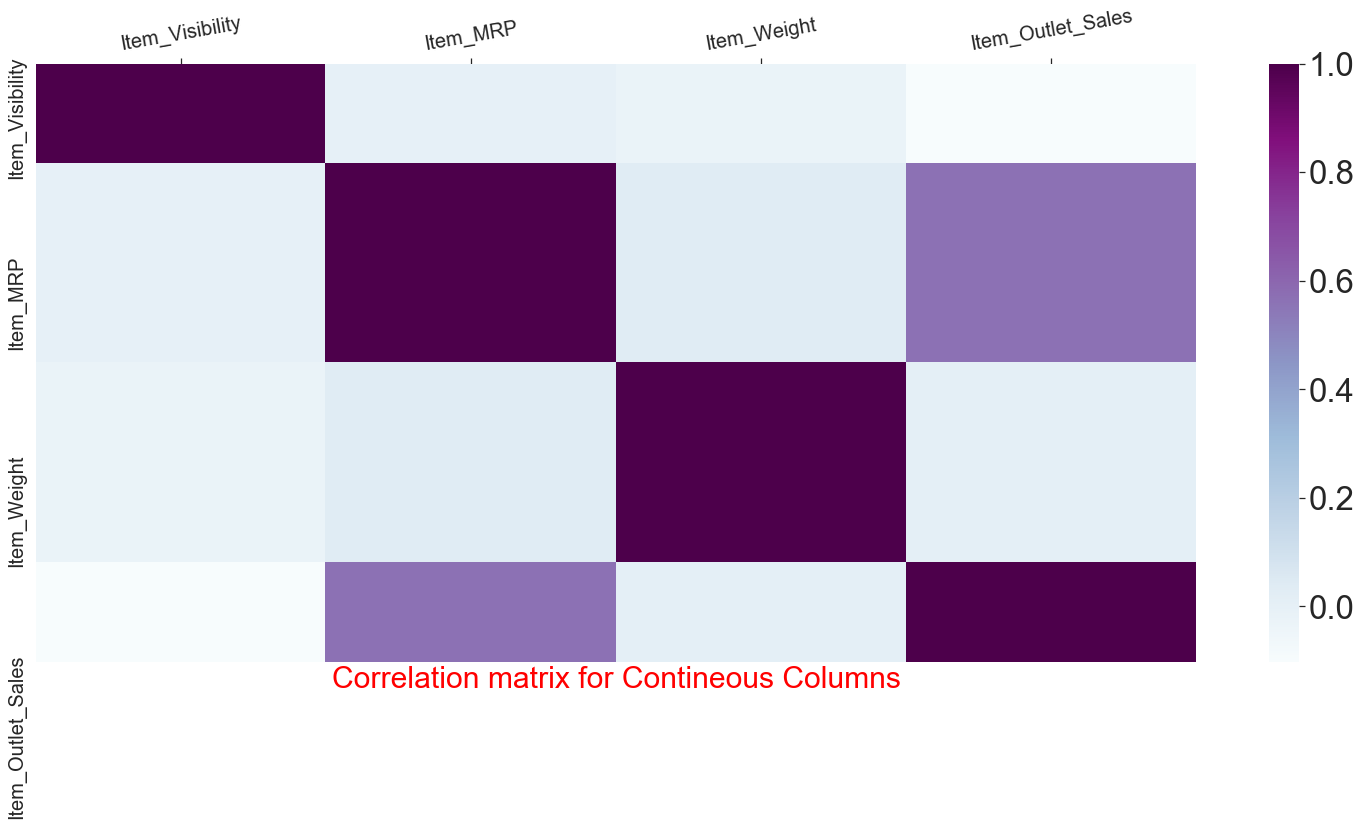

In [56]:
#import seaborn as sns 
correlation_heatmap(conti_cols[1:]+[label_col],data)

# Bivariate Analysis 
### independent Contineous variable and Contineos variable ( label column)

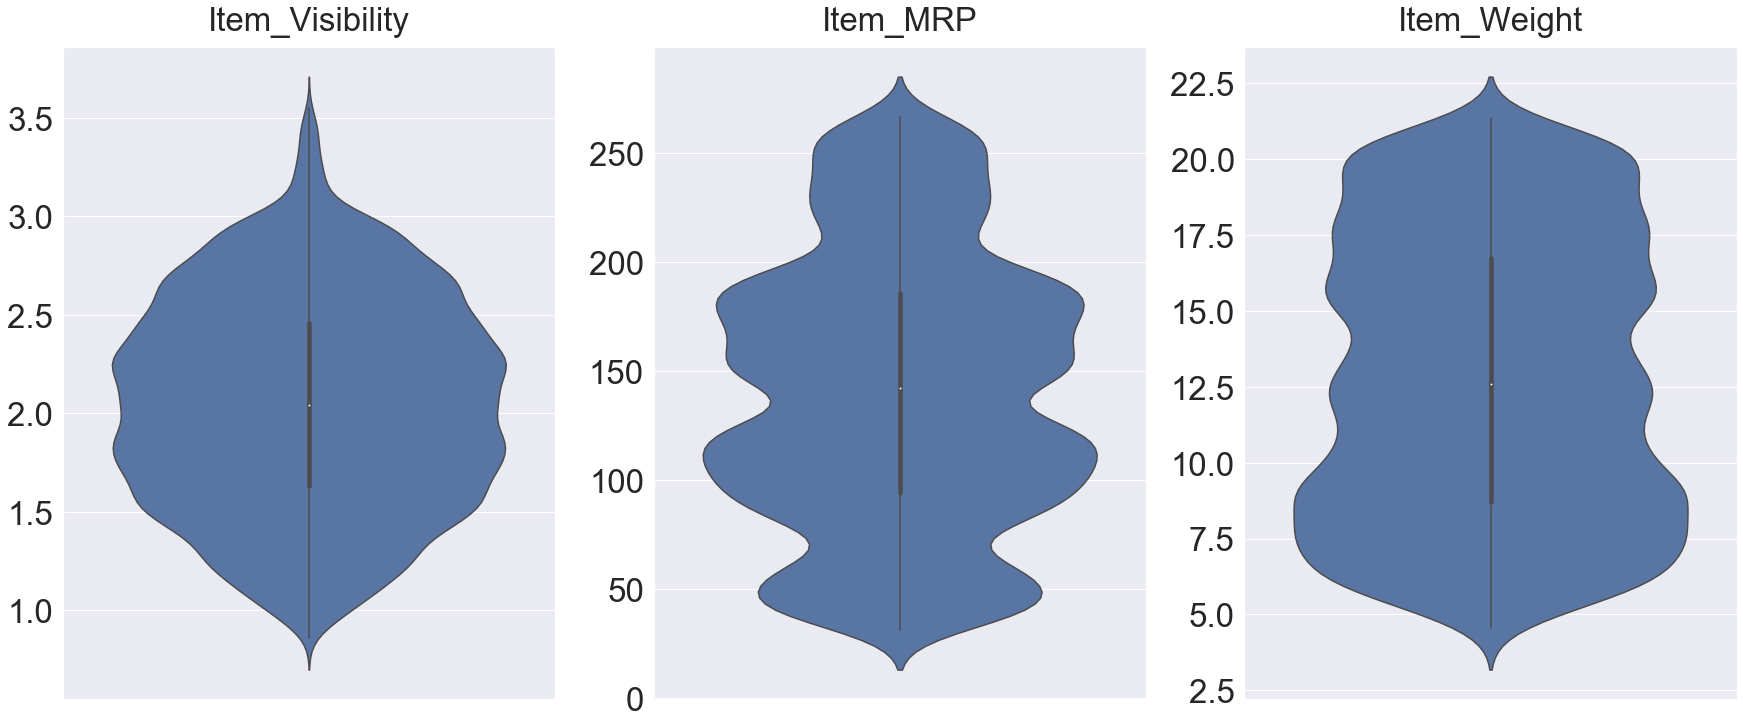

In [57]:
SNS_BoxSubplots_univaricate_Contineous(conti_num_cols,data)

 Lets create Vertical Multi HISTOGRAM plot for column 
['Item_Visibility', 'Item_MRP', 'Item_Weight']


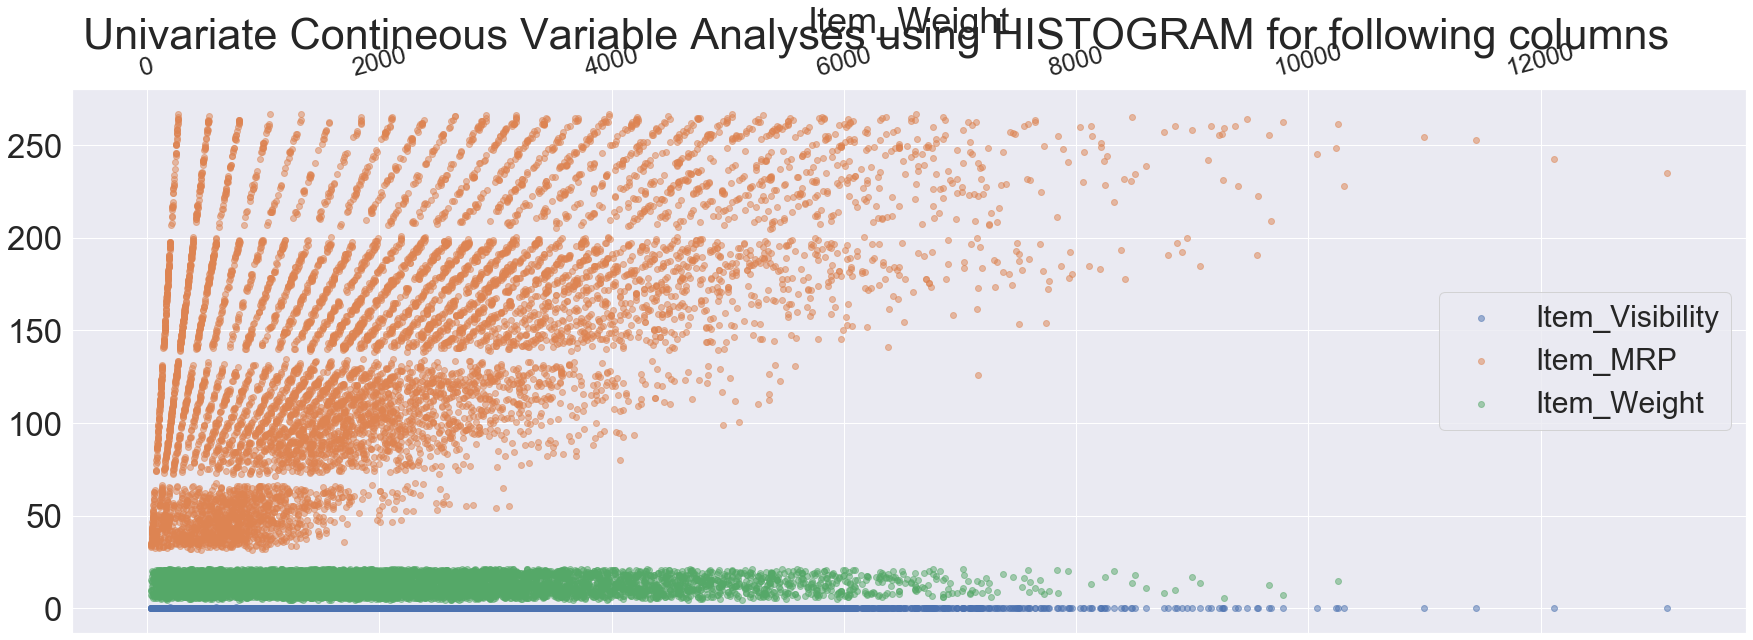

In [58]:
Bivariate_ana_conti_vs_Conti_label_scatter(conti_num_cols,label_col,data_org)

 Lets create Vertical Multi HISTOGRAM plot for column 
['Item_Visibility', 'Item_MRP', 'Item_Weight']


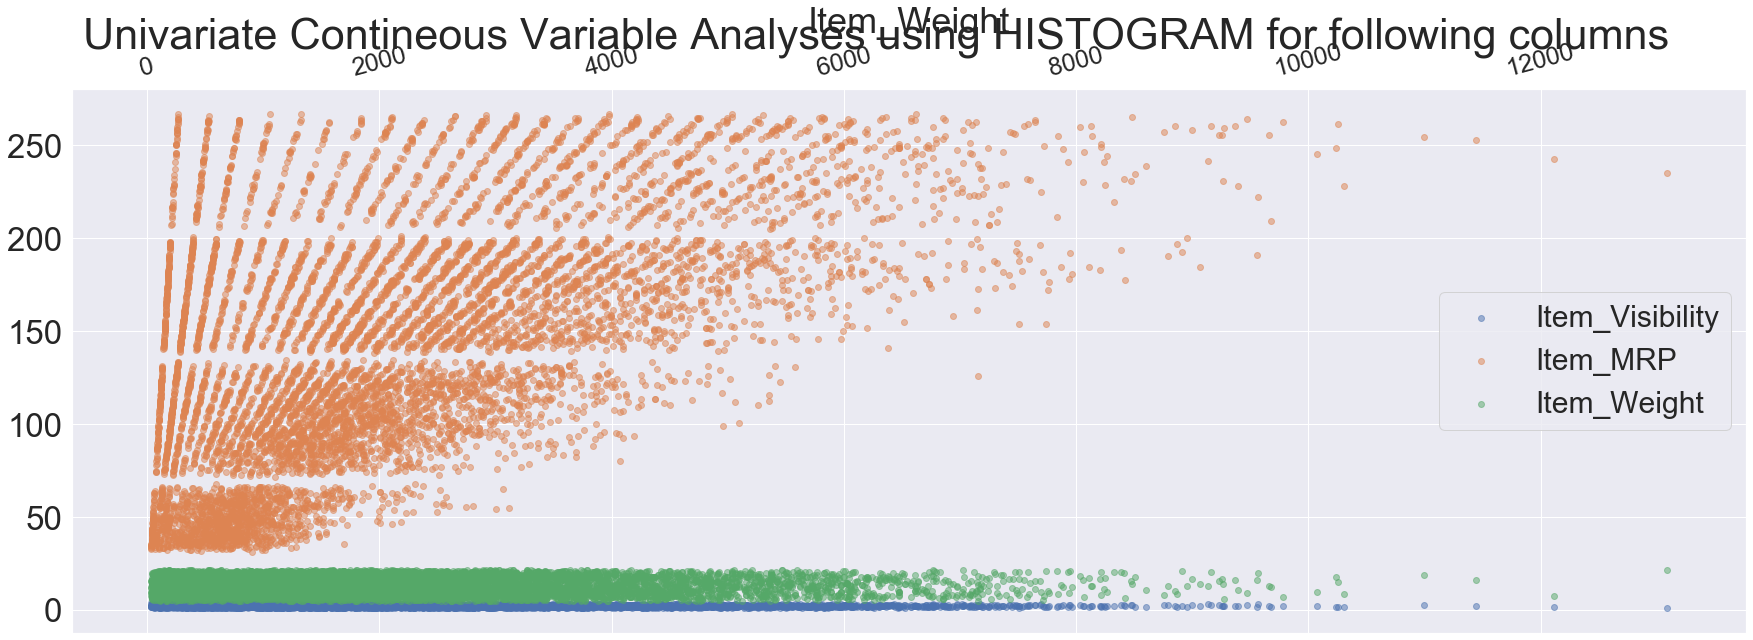

In [59]:
Bivariate_ana_conti_vs_Conti_label_scatter(conti_num_cols,label_col,data)

In [60]:
# lets drop columns Item_MRP as it is correlated with label columns sales
#data=data.drop('Item_MRP',1)

In [61]:
#conti_cols.remove('Item_MRP')


# 1. Data Preprocessing 

In [62]:
# 1 Dummying the Categorical Cols
cat_nominal_cols

['Outlet_Location_Type', 'Outlet_Type', 'Item_Type', 'Item_Category']

In [63]:
#dummyDF = pd.get_dummies(data[cat_nominal_cols])
#data.shape, dummyDF.shape

In [64]:
#cat_nominal_cols

In [65]:
#data=pd.concat([data,dummyDF], axis=1)

In [66]:
#data.drop(cat_nominal_cols,axis=1, inplace=True)

In [67]:
data.shape,data.columns

((14204, 13),
 Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
        'Item_Type', 'Item_Visibility', 'Item_Weight',
        'Outlet_Establishment_Year', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'Item_Category'],
       dtype='object'))

# Standardizing Contineos columns

In [68]:
#Univariate_conti_var_Histogram(conti_cols[1:],np.log(data[conti_cols[1:]]))

In [69]:
#data_org=data.copy()
data_org=data.copy()
std_scale=StandardScaler()
#scaled = std_scale.fit_transform(np.log(data[conti_cols[1:]]))
#scaled = std_scale.fit_transform(data[conti_cols[1:]])
#scaled = pd.DataFrame(scaled,columns=conti_cols[1:])

#Univariate_conti_var_Histogram(conti_cols[1:],scaled)
#data.drop(conti_cols[1:],axis=1,inplace=True)


In [70]:
#Univariate_conti_var_Histogram(conti_cols[1:],scaled)
#data=pd.concat([data,scaled],1)

#data[['Item_Weight','Item_MRP']]=scaled[['Item_MRP','Item_Visibility']]
#conti_cols

In [71]:
data.columns

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Type', 'Item_Visibility', 'Item_Weight',
       'Outlet_Establishment_Year', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'Item_Category'],
      dtype='object')

In [72]:
data_org.columns

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Type', 'Item_Visibility', 'Item_Weight',
       'Outlet_Establishment_Year', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'Item_Category'],
      dtype='object')

In [73]:
#Univariate_conti_var_Histogram(conti_cols,data_org)

In [74]:
data[['Outlet_Location_Type','Outlet_Type','Item_Type','Item_Category']]

Outlet_Location_Type        Outlet_Type              Item_Type  \
0                   Tier 1  Supermarket Type1                  Dairy   
1                   Tier 3  Supermarket Type2            Soft Drinks   
2                   Tier 1  Supermarket Type1                   Meat   
3                   Tier 3      Grocery Store  Fruits and Vegetables   
4                   Tier 3  Supermarket Type1              Household   
5                   Tier 3  Supermarket Type2           Baking Goods   
6                   Tier 3  Supermarket Type1            Snack Foods   
7                   Tier 3  Supermarket Type3            Snack Foods   
8                   Tier 2  Supermarket Type1           Frozen Foods   
9                   Tier 2  Supermarket Type1           Frozen Foods   
10                  Tier 1  Supermarket Type1  Fruits and Vegetables   
11                  Tier 1  Supermarket Type1                  Dairy   
12                  Tier 1  Supermarket Type1  Fruits and Vegetables   
13                  Tier 1  Supermarket Type1            Snack Foods   
14                  Tier 3  Supermarket Type1  Fruits and Vegetables   
15                  Tier 1  Supermarket Type1              Breakfast   
16                  Tier 3  Supermarket Type2     Health and Hygiene   
17                  Tier 1  Supermarket Type1              Breakfast   
18                  Tier 3  Supermarket Type3            Hard Drinks   
19                  Tier 2  Supermarket Type1                  Dairy   
20                  Tier 3  Supermarket Type1            Snack Foods   
21                  Tier 3  Supermarket Type3           Baking Goods   
22                  Tier 2  Supermarket Type1              Household   
23                  Tier 1      Grocery Store           Baking Goods   
24                  Tier 1  Supermarket Type1           Frozen Foods   
25                  Tier 2  Supermarket Type1              Household   
26                  Tier 2  Supermarket Type1            Snack Foods   
27                  Tier 3  Supermarket Type1            Hard Drinks   
28                  Tier 3      Grocery Store                  Dairy   
29                  Tier 1      Grocery Store                 Canned   
...                    ...                ...                    ...   
14174               Tier 3  Supermarket Type1          Starchy Foods   
14175               Tier 2  Supermarket Type1  Fruits and Vegetables   
14176               Tier 2  Supermarket Type1  Fruits and Vegetables   
14177               Tier 3  Supermarket Type1            Snack Foods   
14178               Tier 3  Supermarket Type3  Fruits and Vegetables   
14179               Tier 3  Supermarket Type3                  Dairy   
14180               Tier 1  Supermarket Type1  Fruits and Vegetables   
14181               Tier 3  Supermarket Type1            Snack Foods   
14182               Tier 1  Supermarket Type1            Soft Drinks   
14183               Tier 3  Supermarket Type1            Snack Foods   
14184               Tier 3  Supermarket Type3            Soft Drinks   
14185               Tier 2  Supermarket Type1            Snack Foods   
14186               Tier 3  Supermarket Type2            Soft Drinks   
14187               Tier 3  Supermarket Type2            Soft Drinks   
14188               Tier 3  Supermarket Type3                  Dairy   
14189               Tier 1  Supermarket Type1            Snack Foods   
14190               Tier 1  Supermarket Type1            Snack Foods   
14191               Tier 3      Grocery Store  Fruits and Vegetables   
14192               Tier 3  Supermarket Type3  Fruits and Vegetables   
14193               Tier 2  Supermarket Type1                   Meat   
14194               Tier 1  Supermarket Type1                 Canned   
14195               Tier 1  Supermarket Type1              Household   
14196               Tier 3  Supermarket Type2            Snack Foods   
14197               Tier 1  Supermarket Type1 

In [75]:
#data=pd.concat([data,scaled],axis=1)
data.shape,data_org.shape
data[cat_cols].head(10)

Outlet_Location_Type        Outlet_Type              Item_Type  \
0               Tier 1  Supermarket Type1                  Dairy   
1               Tier 3  Supermarket Type2            Soft Drinks   
2               Tier 1  Supermarket Type1                   Meat   
3               Tier 3      Grocery Store  Fruits and Vegetables   
4               Tier 3  Supermarket Type1              Household   
5               Tier 3  Supermarket Type2           Baking Goods   
6               Tier 3  Supermarket Type1            Snack Foods   
7               Tier 3  Supermarket Type3            Snack Foods   
8               Tier 2  Supermarket Type1           Frozen Foods   
9               Tier 2  Supermarket Type1           Frozen Foods   

  Item_Fat_Content Outlet_Size  Outlet_Establishment_Year   Item_Category  
0               LF      Medium                         14            Food  
1          Regular      Medium                         24          Drinks  
2               LF      Medium                         14            Food  
3          Regular       Small                         13            Food  
4               LF        High                          2  Non-Consumable  
5          Regular      Medium                         24            Food  
6          Regular        High                          2            Food  
7               LF      Medium                          0            Food  
8          Regular       Small                         17            Food  
9          Regular       Small                         22            Food

In [76]:
# get dummies
nomi_cols=['Outlet_Location_Type','Outlet_Type','Item_Type','Item_Category']
dummies_data=pd.get_dummies(data[nomi_cols])
data = data.drop(nomi_cols,1)
data=pd.concat([data,dummies_data], axis=1)


In [77]:
data.head(5)

Item_Fat_Content Item_Identifier  Item_MRP  Item_Outlet_Sales  \
0               LF           FDA15  249.8092          3735.1380   
1          Regular           DRC01   48.2692           443.4228   
2               LF           FDN15  141.6180          2097.2700   
3          Regular           FDX07  182.0950           732.3800   
4               LF           NCD19   53.8614           994.7052   

   Item_Visibility  Item_Weight  Outlet_Establishment_Year Outlet_Identifier  \
0         1.282247         9.30                         14            OUT049   
1         1.368085         5.92                         24            OUT018   
2         1.301827        17.50                         14            OUT049   
3         1.330632        19.20                         13            OUT010   
4         1.091246         8.93                          2            OUT013   

  Outlet_Size  Outlet_Location_Type_Tier 1  ...  Item_Type_Household  \
0      Medium                            1  ...                    0   
1      Medium                            0  ...                    0   
2      Medium                            1  ...                    0   
3       Small                            0  ...                    0   
4        High                            0  ...                    1   

   Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
0               0                 0                  0                      0   
1               0                 0                  0                      0   
2               1                 0                  0                      0   
3               0                 0                  0                      0   
4               0                 0                  0                      0   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  Item_Category_Drinks  \
0                      0                        0                     0   
1                      1                        0                     1   
2                      0                        0                     0   
3                      0                        0                     0   
4                      0                        0                     0   

   Item_Category_Food  Item_Category_Non-Consumable  
0                   1                             0  
1                   0                             0  
2                   1                             0  
3                   1                             0  
4                   0                             1  

[5 rows x 35 columns]

In [78]:
# Action 4 (Encoding Label - Outlet_Identifier)
data1=pd.DataFrame()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in ['Item_Fat_Content','Outlet_Size']+cat_id_cols:
    data[i]=le.fit_transform(data[i])

data

Item_Fat_Content Item_Identifier  Item_MRP  Item_Outlet_Sales  \
0                     0           FDA15  249.8092          3735.1380   
1                     1           DRC01   48.2692           443.4228   
2                     0           FDN15  141.6180          2097.2700   
3                     1           FDX07  182.0950           732.3800   
4                     0           NCD19   53.8614           994.7052   
5                     1           FDP36   51.4008           556.6088   
6                     1           FDO10   57.6588           343.5528   
7                     0           FDP10  107.7622          4022.7636   
8                     1           FDH17   96.9726          1076.5986   
9                     1           FDU28  187.8214          4710.5350   
10                    0           FDY07   45.5402          1516.0266   
11                    1           FDA03  144.1102          2187.1530   
12                    1           FDX32  145.4786          1589.2646   
13                    1           FDS46  119.6782          2145.2076   
14                    0           FDF32  196.4426          1977.4260   
15                    1           FDP49   56.3614          1547.3192   
16                    0           NCB42  115.3492          1621.8888   
17                    1           FDP49   54.3614           718.3982   
18                    0           DRI11  113.2834          2303.6680   
19                    0           FDU02  230.5352          2748.4224   
20                    1           FDN22  250.8724          3775.0860   
21                    1           FDW12  144.5444          4064.0432   
22                    0           NCB30  196.5084          1587.2672   
23                    0           FDC37  107.6938           214.3876   
24                    1           FDR28  165.0210          4078.0250   
25                    0           NCD06   45.9060           838.9080   
26                    1           FDV10   42.3112          1065.2800   
27                    0           DRJ59   39.1164           308.9312   
28                    1           FDE51   45.5086           178.4344   
29                    1           FDC14   43.6454           125.8362   
...                 ...             ...       ...                ...   
14174                 1           FDD23  186.1898                NaN   
14175                 0           FDP32  126.7678                NaN   
14176                 1           FDO31   80.2960                NaN   
14177                 0           FDQ57  144.5760                NaN   
14178                 1           FDX32  143.6786                NaN   
14179                 0           FDC39  207.8296                NaN   
14180                 0           FDU55  261.3278                NaN   
14181                 0           FDL45  123.4704                NaN   
14182                 0           DRK37  188.8530                NaN   
14183                 0           FDK22  215.3850                NaN   
14184                 0           DRG37  155.7972                NaN   
14185                 0           FDK22  214.3850                NaN   
14186                 0           DRH36   72.8696                NaN   
14187                 1           DRC36  173.4054                NaN   
14188                 0           DRE03   46.0718                NaN   
14189                 1           FDF34  196.9084                NaN   
14190                 0           FDZ22   82.1250                NaN   
14191                 0           FDC44  115.1518                NaN   
14192                 0           FDN31  188.0530                NaN   
14193                 1           FDO03  229.4352                NaN   
14194                 1           FDA01   59.5904                NaN   
14195                 0           NCH42  231.1010                NaN   
14196                 0           FDF46  116.0834                NaN   
14197                 0           DRL35   43.27

In [79]:
data.head(3)

Item_Fat_Content Item_Identifier  Item_MRP  Item_Outlet_Sales  \
0                 0           FDA15  249.8092          3735.1380   
1                 1           DRC01   48.2692           443.4228   
2                 0           FDN15  141.6180          2097.2700   

   Item_Visibility  Item_Weight  Outlet_Establishment_Year  Outlet_Identifier  \
0         1.282247         9.30                         14                  9   
1         1.368085         5.92                         24                  3   
2         1.301827        17.50                         14                  9   

   Outlet_Size  Outlet_Location_Type_Tier 1  ...  Item_Type_Household  \
0            1                            1  ...                    0   
1            1                            0  ...                    0   
2            1                            1  ...                    0   

   Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
0               0                 0                  0                      0   
1               0                 0                  0                      0   
2               1                 0                  0                      0   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  Item_Category_Drinks  \
0                      0                        0                     0   
1                      1                        0                     1   
2                      0                        0                     0   

   Item_Category_Food  Item_Category_Non-Consumable  
0                   1                             0  
1                   0                             0  
2                   1                             0  

[3 rows x 35 columns]

In [80]:
conti_cols
data_org=data.copy()
data=data.drop(['Item_Identifier'],1)

In [81]:
data.shape

(14204, 34)

In [82]:
train.shape

(8523, 12)

In [83]:
trainDF=data[:8523]

In [84]:
testDF=data[8523:]
test_org=data_org[8523:]

In [85]:
#data_org=data.copy()
#data=data.drop(['Item_Identifier'],1)

In [86]:
trainDF.shape,testDF.shape

((8523, 34), (5681, 34))

In [87]:
#trainDF['Item_Identifier']  #data['Item_Identifier']

In [88]:
ytrainDF=trainDF.Item_Outlet_Sales

In [89]:
xtrainDF=trainDF.drop(['Item_Outlet_Sales'],1)
testDF=testDF.drop(['Item_Outlet_Sales'],1)


In [90]:
xtrainDF.shape,testDF.shape

((8523, 33), (5681, 33))

In [91]:
desc(xtrainDF)
data_org.head(5)

Item_Fat_Content Item_Identifier  Item_MRP  Item_Outlet_Sales  \
0                 0           FDA15  249.8092          3735.1380   
1                 1           DRC01   48.2692           443.4228   
2                 0           FDN15  141.6180          2097.2700   
3                 1           FDX07  182.0950           732.3800   
4                 0           NCD19   53.8614           994.7052   

   Item_Visibility  Item_Weight  Outlet_Establishment_Year  Outlet_Identifier  \
0         1.282247         9.30                         14                  9   
1         1.368085         5.92                         24                  3   
2         1.301827        17.50                         14                  9   
3         1.330632        19.20                         13                  0   
4         1.091246         8.93                          2                  1   

   Outlet_Size  Outlet_Location_Type_Tier 1  ...  Item_Type_Household  \
0            1                            1  ...                    0   
1            1                            0  ...                    0   
2            1                            1  ...                    0   
3            2                            0  ...                    0   
4            0                            0  ...                    1   

   Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
0               0                 0                  0                      0   
1               0                 0                  0                      0   
2               1                 0                  0                      0   
3               0                 0                  0                      0   
4               0                 0                  0                      0   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  Item_Category_Drinks  \
0                      0                        0                     0   
1                      1                        0                     1   
2                      0                        0                     0   
3                      0                        0                     0   
4                      0                        0                     0   

   Item_Category_Food  Item_Category_Non-Consumable  
0                   1                             0  
1                   0                             0  
2                   1                             0  
3                   1                             0  
4                   0                             1  

[5 rows x 35 columns]

# 4. Model Building

In [92]:
# Bench mark Score
#Mean based:
mean_sales = ytrainDF.mean()
print("Mean sale of Train Data = %0.2f" %mean_sales)
#Define a dataframe with IDs for submission:
base1 = train[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

Mean sale of Train Data = 2181.29


/Users/keeratjohar2305/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [409]:
pred_all=pd.DataFrame()
pred_all_test=pd.DataFrame()
def generate_submission_file(submission_csv_name,model,org_test,cleaned_test):
    y_pred = model.predict(cleaned_test)

#Export submission file:
    org_test['Item_Outlet_Sales']=y_pred
    submission=org_test[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
    submission.to_csv(submission_csv_name, index=False)
    return y_pred
def getTranindDataPrediction(model,yTrainingData):
    y_pred = model.predict(yTrainingData)
    return pd.Series(y_pred)

# 1.1 Linear Regression
# 1.2 Linear Regression GridSearch
# 1.3 Linear Regression Bagging

In [618]:
xtrainDF.columns

Index(['Item_Fat_Content', 'Item_MRP', 'Item_Visibility', 'Item_Weight',
       'Outlet_Establishment_Year', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Item_Category_Drinks', 'Item_Category_Food',
       'Item_Category_Non-Consumable'],
      dtype='object')

In [619]:
trDF=xtrainDF.copy()
ttDF=testDF.copy()
trDF['Item_v1']=-1*xtrainDF.Item_Weight*xtrainDF.Item_Visibility
ttDF['Item_v1']=testDF.Item_MRP*testDF.Item_Visibility

In [620]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
linear_model= LinearRegression()
regressionModelfit_CV(linear_model,xtrainDF.columns, trDF, ytrainDF)
#pd.Series(linear_model.coef_, xtrainDF.columns).sort_values().plot.bar()

fit_time =0.01
score_time =0.01
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =29.01
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1135.34
train_neg_mean_squared_error =1126.84


# 1.1

In [387]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
linear_model= LinearRegression()
regressionModelfit_CV(linear_model,xtrainDF.columns, xtrainDF, ytrainDF)
#pd.Series(linear_model.coef_, xtrainDF.columns).sort_values().plot.bar()


fit_time =0.01
score_time =0.01
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.97
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1132.35
train_neg_mean_squared_error =1127.79


In [410]:
generate_submission_file('SampleSubmission_LR1.csv',linear_model,test,testDF)
pred_all['LR']=linear_model.predict(xtrainDF)
pred_all_test['LR']=linear_model.predict(testDF)



# 1.2

In [95]:
# Grid search - this will take about 1 minute.
param_grid = {
    'fit_intercept': [True,False],
    'normalize': [True,False],

}
lr_clf = GridSearchCV(linear_model, param_grid,verbose=1,n_jobs=-1).fit(xtrainDF, ytrainDF)
#regressionModelfit_CV(SGD,xtrainDF.columns, X_train1, ytrainDF)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.7s finished


In [314]:
print(lr_clf.best_score_)
print(lr_clf.best_estimator_)
regressionModelfit_CV(lr_clf.best_estimator_,xtrainDF.columns, xtrainDF, ytrainDF)

0.5577859912855123
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
fit_time =0.01
score_time =0.01
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.97
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1132.35
train_neg_mean_squared_error =1127.79


In [341]:
generate_submission_file('SampleSubmission_LR2.csv',linear_model,test,testDF)


array([1853.4201901 , 1541.28263012, 1883.32010873, ..., 1898.82214979,
       3587.86811269, 1364.21885765])

# 1.3

In [97]:
from sklearn.ensemble import BaggingRegressor
linear_model= LinearRegression()
ensembleLR = BaggingRegressor(base_estimator=linear_model,                            
                                bootstrap=True,
                                random_state=0,
                                verbose=0)#.fit( xtrainDF, ytrainDF)

In [98]:
regressionModelfit_CV(ensembleLR,xtrainDF.columns, xtrainDF, ytrainDF)

fit_time =0.15
score_time =0.01
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.96
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1132.46
train_neg_mean_squared_error =1128.02


In [99]:
linear_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

# 2.1 Stochastic Gradient Descent Regressor
# 2.2 Stochastic Gradient Descent Regressor with Hyper parameter tuning
# 2.3 Stochastic Gradient Descent Regressor with Bagging

# 2.1

In [317]:

# Note: Stochastic Gradient Descent is sensitive to feature scaling, so it is highly recommended to scale your data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xtrainDF)  # Don't cheat - fit only on training data
X_train1 = pd.DataFrame(scaler.transform(xtrainDF),columns=xtrainDF.columns)
from sklearn.linear_model import SGDRegressor #, penalty=None,loss="squared_loss"
SGD=SGDRegressor(alpha=0.5)
regressionModelfit_CV(SGD,xtrainDF.columns, X_train1, ytrainDF)

fit_time =0.03
score_time =0.00
test_r2 =0.50
train_r2 =0.51
test_neg_mean_absolute_error =29.87
train_neg_mean_absolute_error =29.83
test_neg_mean_squared_error =1202.25
train_neg_mean_squared_error =1200.49


In [389]:

generate_submission_file('SampleSubmission_LR2.csv',SGD,test,testDF)


array([ 71742.57645358,  57572.75999529, 155293.51056519, ...,
        78252.47145553, 138616.61468783,  53488.24702636])

# 2.2

In [101]:
# Grid search - this will take about 1 minute.
param_grid = {
    'alpha': [0.5,1,5,10],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
SGD=SGDRegressor(alpha=0.5)
sgd_clf = GridSearchCV(SGD, param_grid,verbose=1,n_jobs=-1).fit(X_train1, ytrainDF)
#regressionModelfit_CV(SGD,xtrainDF.columns, X_train1, ytrainDF)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  2.5min finished


In [103]:
print(sgd_clf.best_score_)
print(sgd_clf.best_estimator_)
regressionModelfit_CV(sgd_clf.best_estimator_,xtrainDF.columns, X_train1, ytrainDF)

0.5601819165724533
SGDRegressor(alpha=10, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
fit_time =0.06
score_time =0.00
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.94
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1131.53
train_neg_mean_squared_error =1129.59


In [411]:
pred_all['SGD']=sgd_clf.best_estimator_.predict(xtrainDF)
pred_all_test['SGD']=sgd_clf.best_estimator_.predict(testDF)

# 2.3

In [106]:
ensembleSGDR = BaggingRegressor(base_estimator=sgd_clf.best_estimator_,n_estimators=250,
                                bootstrap=True,
                                random_state=0,
                                verbose=1)#.fit( X_train1, ytrainDF)
regressionModelfit_CV(ensembleSGDR,xtrainDF.columns, X_train1, ytrainDF)

fit_time =11.89
score_time =0.08
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.93
train_neg_mean_absolute_error =28.90
test_neg_mean_squared_error =1131.22
train_neg_mean_squared_error =1128.80


# 3.1 Ridge Regularization 
# 3.2 Ridge Regularization with hyperparameter tuning
# 3.3 Ridge Regularization with baggingReggressor
# 3.4 Lasso Regularization
# 3.5 Lasso Regularization with hyperparameter tuning
# 3.6 Lasso Regularization with baggingReggressor
# 3.7 ElasticNet Regularization
# 3.8 ElasticNet Regularization with hyperparameter tuning
# 3.9 ElasticNet Regularization with baggingReggressor

# 3.1

In [156]:
#predictors = [x for x in train.columns if x not in [target]+IDcol]
RigReg = Ridge(random_state=30,alpha=3)
print(RigReg)
regressionModelfit_CV(RigReg,xtrainDF.columns, xtrainDF, ytrainDF)
#pd.Series(alg2.coef_, xtrainDF.columns).sort_values().plot.bar()
#generate_submission_file('SampleSubmission_RIG2.csv',alg2,test,testDF)

Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=30, solver='auto', tol=0.001)
fit_time =0.01
score_time =0.01
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.97
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1132.31
train_neg_mean_squared_error =1127.79


In [412]:
pred_all['RigReg']=RigReg.predict(xtrainDF)
pred_all_test['RigReg']=RigReg.predict(testDF)
generate_submission_file('SampleSubmission_LR2.csv',RigReg,test,testDF)

array([1854.81296635, 1535.21317393, 1888.25926751, ..., 1903.71256584,
       3579.92095013, 1368.83683421])

In [122]:
3.2

3.2

In [157]:
param_dist = {"alpha": [1,0.8,0.5,0.1,0.01,0.001,0.0001,3,5,10,11,12,15,20,20, 25,26, 35, 50],
              'fit_intercept': [True,False],
              'normalize': [True,False]
              }



In [158]:
rig_estimators = GridSearchCV(estimator=RigReg, param_grid=param_dist).fit(xtrainDF,ytrainDF)
print(rig_estimators.best_score_)
print(rig_estimators.best_estimator_)

0.5579864785646013
Ridge(alpha=11, copy_X=True, fit_intercept=False, max_iter=None, normalize=True,
      random_state=30, solver='auto', tol=0.001)


In [159]:
regressionModelfit_CV(rig_estimators.best_estimator_,xtrainDF.columns, xtrainDF, ytrainDF)

fit_time =0.01
score_time =0.01
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.96
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1132.28
train_neg_mean_squared_error =1127.90


In [123]:
3.3

3.3

In [165]:
ensembleSGDR = BaggingRegressor(base_estimator=rig_estimators.best_estimator_ ,n_estimators=200,
                                bootstrap=True,
                                random_state=0,
                                verbose=0,n_jobs=-1)#.fit( X_train1, ytrainDF)
regressionModelfit_CV(ensembleSGDR,xtrainDF.columns, X_train1, ytrainDF)

fit_time =0.84
score_time =0.15
test_r2 =-1.10
train_r2 =-1.07
test_neg_mean_absolute_error =46.97
train_neg_mean_absolute_error =46.90
test_neg_mean_squared_error =2463.53
train_neg_mean_squared_error =2455.49


# Lasso regresssion Regularisation  
3.4

In [115]:
#predictors = [x for x in train.columns if x not in [target]+IDcol]
LassoReg = Lasso(random_state=30)
regressionModelfit_CV(LassoReg,xtrainDF.columns, xtrainDF, ytrainDF)
#pd.Series(alg2.coef_, xtrainDF.columns).sort_values().plot.bar()
#generate_submission_file('SampleSubmission_RIG2.csv',alg2,test,testDF)
#predictors = [x for x in train.columns if x not in [target]+IDcol]


fit_time =0.03
score_time =0.00
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.95
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1131.13
train_neg_mean_squared_error =1128.01


In [413]:
pred_all['LassoReg']=LassoReg.predict(xtrainDF)
pred_all_test['LassoReg']=LassoReg.predict(testDF)
generate_submission_file('SampleSubmission_LR2.csv',LassoReg,test,testDF)

array([1842.15002367, 1535.54305955, 1901.42087882, ..., 1917.10653384,
       3544.58819574, 1371.57484655])

In [127]:
3.5

3.5

In [168]:
param_dist = {"alpha": [1,0.8,0.5,0.1,0.01,0.001,0.0001,3,5,10,11,12,15],
              'fit_intercept': [True,False],
              'normalize': [True,False],
              #'tol':[.001,.002,.005,.008],
              'max_iter':[500,1000],
              'selection':['cyclic','random']
              
              }
lasso_estimators = GridSearchCV(estimator=LassoReg, param_grid=param_dist).fit(xtrainDF,ytrainDF)
print(lasso_estimators.best_score_)
print(lasso_estimators.best_estimator_)
regressionModelfit_CV(lasso_estimators.best_estimator_,xtrainDF.columns, xtrainDF, ytrainDF)

0.5605607288147397
Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=500, normalize=False,
      positive=False, precompute=False, random_state=30, selection='cyclic',
      tol=0.0001, warm_start=False)
fit_time =0.02
score_time =0.01
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.93
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1130.97
train_neg_mean_squared_error =1129.24


In [128]:
3.6

3.6

In [169]:
ensembleSGDR = BaggingRegressor(base_estimator=lasso_estimators.best_estimator_ ,n_estimators=200,
                                bootstrap=True,
                                random_state=0,
                                verbose=0,n_jobs=-1)#.fit( X_train1, ytrainDF)
regressionModelfit_CV(ensembleSGDR,xtrainDF.columns, X_train1, ytrainDF)

fit_time =3.12
score_time =0.20
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.95
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1131.71
train_neg_mean_squared_error =1128.31


# Elastic Net Linear Regularisation
3.7

In [171]:
ElasticeNetReg = ElasticNet(random_state=30)
regressionModelfit_CV(ElasticeNetReg,xtrainDF.columns, xtrainDF, ytrainDF)

fit_time =0.01
score_time =0.00
test_r2 =0.45
train_r2 =0.46
test_neg_mean_absolute_error =30.45
train_neg_mean_absolute_error =30.44
test_neg_mean_squared_error =1259.12
train_neg_mean_squared_error =1257.69


In [362]:
generate_submission_file('SampleSubmission_LR2.csv',ElasticeNetReg,test,testDF)

array([2119.21911881,  989.75071719, 2828.56838554, ..., 2035.99122169,
       2930.23874313, 1449.0248997 ])

In [170]:
3.8

3.8

In [172]:
param_dist = {"alpha": [1,0.8,0.5,0.1,0.01,0.001,0.0001,3,5,10,11,12,15],
              'fit_intercept': [True,False],
              'normalize': [True,False],
              #'tol':[.001,.002,.005,.008],
              'max_iter':[500,1000],
              'selection':['cyclic','random']
              
              }
ElasticeNetReg_estimators = GridSearchCV(estimator=ElasticeNetReg, param_grid=param_dist).fit(xtrainDF,ytrainDF)
print(ElasticeNetReg_estimators.best_score_)
print(ElasticeNetReg_estimators.best_estimator_)
regressionModelfit_CV(ElasticeNetReg_estimators.best_estimator_,xtrainDF.columns, xtrainDF, ytrainDF)

0.5578827904777665
ElasticNet(alpha=0.001, copy_X=True, fit_intercept=False, l1_ratio=0.5,
           max_iter=500, normalize=True, positive=False, precompute=False,
           random_state=30, selection='random', tol=0.0001, warm_start=False)
fit_time =0.15
score_time =0.00
test_r2 =0.56
train_r2 =0.56
test_neg_mean_absolute_error =28.97
train_neg_mean_absolute_error =28.91
test_neg_mean_squared_error =1132.29
train_neg_mean_squared_error =1127.80


In [414]:
pred_all['ElasticeNetReg']=ElasticeNetReg.predict(xtrainDF)
pred_all_test['ElasticeNetReg']=ElasticeNetReg.predict(testDF)

In [173]:
3.9

3.9

In [174]:
ensembleSGDR = BaggingRegressor(base_estimator=ElasticeNetReg_estimators.best_estimator_ ,n_estimators=200,
                                bootstrap=True,
                                random_state=0,
                                verbose=0,n_jobs=-1)#.fit( X_train1, ytrainDF)
regressionModelfit_CV(ensembleSGDR,xtrainDF.columns, X_train1, ytrainDF)

fit_time =26.86
score_time =0.18
test_r2 =-1.10
train_r2 =-1.07
test_neg_mean_absolute_error =46.97
train_neg_mean_absolute_error =46.90
test_neg_mean_squared_error =2463.54
train_neg_mean_squared_error =2455.49


# 4.1 Decision Tree
# 4.2 Decision Tree with RandomizedSearchCV
# 4.3 Decision Tree with BaggingRegressor

In [178]:
4.1

4.1

In [179]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
print(dt)
regressionModelfit_CV(dt,xtrainDF.columns, xtrainDF, ytrainDF)
#pd.Series(alg3.feature_importances_, xtrainDF.columns).sort_values(ascending=False).plot.bar()
#feature_imp_cols=pd.Series(alg3.feature_importances_, xtrainDF.columns).sort_values(ascending=False)[:14]
generate_submission_file('SampleSubmission_DT1.csv',dt,test,testDF)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=100,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
fit_time =0.03
score_time =0.00
test_r2 =0.59
train_r2 =0.61
test_neg_mean_absolute_error =27.68
train_neg_mean_absolute_error =27.27
test_neg_mean_squared_error =1090.74
train_neg_mean_squared_error =1059.91


In [415]:
pred_all['dt']=dt.predict(xtrainDF)
pred_all_test['dt']=dt.predict(testDF)
generate_submission_file('SampleSubmission_LR2.csv',dt,test,testDF)

array([1690.23408624, 1412.15620504,  584.75776477, ..., 1796.04886565,
       3737.29577518, 1240.36730761])

In [180]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

param_dist = {"criterion": ["mse", "mae"],
              "min_samples_split": sp_randint(1,100),
              "max_depth":  sp_randint(2,16),
              "min_samples_leaf": sp_randint(2,200),
              "max_leaf_nodes": [5, 20, 100],
              "max_features": sp_randint(1,10)
              }

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [100,130,160],
              "max_depth":  [14,16,18]
#               "min_samples_leaf": [10,20,40,60,70,90,110],
#               "max_leaf_nodes": [5, 20, 100],
#               "max_features": [1,2,4,6,8,9,10]
              }
n_iter_search = 20
# clfrs = RandomizedSearchCV(alg3, 
#                                    param_distributions=param_dist,
#                                    scoring='neg_mean_squared_error',
#                                    cv=5 , n_jobs=-1, verbose=1,
#                                    n_iter=n_iter_search)

clfrs = GridSearchCV(dt, 
                                   param_grid=param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=-1, verbose=2
                                  )
#grid_estimators = GridSearchCV(estimator=alg2, param_grid=dict(alpha=alphas))

clfrs.fit(xtrainDF,ytrainDF)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:  1.5min remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=15,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=100,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [14, 16, 18],
                         'min_samples_split': [100, 130, 160]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [183]:
print(clfrs.best_params_)
print(clfrs.best_estimator_)
regressionModelfit_CV(clfrs.best_estimator_,xtrainDF.columns, xtrainDF, ytrainDF)

{'criterion': 'mse', 'max_depth': 14, 'min_samples_split': 130}
DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=100,
                      min_samples_split=130, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
fit_time =0.03
score_time =0.00
test_r2 =0.59
train_r2 =0.61
test_neg_mean_absolute_error =27.68
train_neg_mean_absolute_error =27.27
test_neg_mean_squared_error =1090.74
train_neg_mean_squared_error =1059.91


In [398]:
generate_submission_file('SampleSubmission_DT2.csv',clfrs.best_estimator_,test,testDF)

array([1690.23408624, 1412.15620504,  584.75776477, ..., 1796.04886565,
       3737.29577518, 1240.36730761])

# 1.3

In [208]:
from sklearn.ensemble import BaggingRegressor
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_split=100)
ensemble = BaggingRegressor(base_estimator=alg3,
                                max_samples=1.0,
                                bootstrap=True,
                                random_state=0,
                                n_estimators = 1000,
                                verbose=0)#.fit( xtrainDF, ytrainDF)


In [606]:
regressionModelfit_CV(ensemble,xtrainDF.columns, xtrainDF, ytrainDF)
generate_submission_file('SampleSubmission_LR2.csv',dt,test,testDF)

fit_time =19.41
score_time =1.36
test_r2 =0.59
train_r2 =0.65
test_neg_mean_absolute_error =27.58
train_neg_mean_absolute_error =26.52
test_neg_mean_squared_error =1087.24
train_neg_mean_squared_error =1003.29


array([1690.23408624, 1412.15620504,  584.75776477, ..., 1796.04886565,
       3737.29577518, 1240.36730761])

In [416]:
pred_all['dtbag']=ensemble.predict(xtrainDF)
pred_all_test['dtbag']=ensemble.predict(testDF)

In [232]:
ensemble.fit( xtrainDF, ytrainDF)
generate_submission_file('SampleSubmission_DT3.csv',ensemble,test,testDF)

# 2.1 Random forest
# 2.2 Randome forest with RandomizedSearchCV

## 2.1 

In [366]:
from sklearn.ensemble import RandomForestRegressor
alg6 = RandomForestRegressor(n_estimators=1000,max_depth=15,  min_samples_split=100,n_jobs=-1)
regressionModelfit_CV(alg6,xtrainDF.columns, xtrainDF, ytrainDF)
#pd.Series(alg6.feature_importances_, xtrainDF.columns).sort_values().plot.bar(title='Random For-Feature Importances')
generate_submission_file('SampleSubmission_RF1.csv',alg6,test,testDF)

fit_time =12.66
score_time =0.77
test_r2 =0.59
train_r2 =0.66
test_neg_mean_absolute_error =27.55
train_neg_mean_absolute_error =26.50
test_neg_mean_squared_error =1085.13
train_neg_mean_squared_error =1001.59


array([1598.23202386, 1305.99087715,  582.97231317, ..., 1841.06690874,
       3636.15262582, 1340.3903616 ])

In [367]:
print(alg6)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=100,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [417]:
pred_all['rf']=alg6.predict(xtrainDF)
pred_all_test['rf']=alg6.predict(testDF)

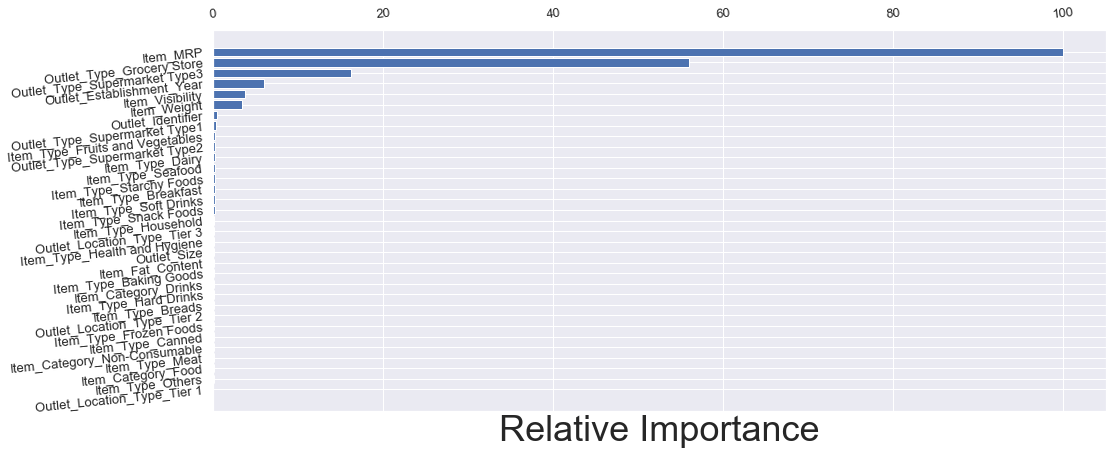

Index(['Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Breakfast',
       'Item_Type_Starchy Foods', 'Item_Type_Seafood', 'Item_Type_Dairy',
       'Outlet_Type_Supermarket Type2', 'Item_Type_Fruits and Vegetables',
       'Outlet_Type_Supermarket Type1', 'Outlet_Identifier', 'Item_Weight',
       'Item_Visibility', 'Outlet_Establishment_Year',
       'Outlet_Type_Supermarket Type3', 'Outlet_Type_Grocery Store',
       'Item_MRP'],
      dtype='object')

In [306]:
feature_importance=alg6.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
fig= plt.figure(figsize=(16,7))
plt.yticks(rotation=6,fontsize=13)
plt.xticks(rotation=6,fontsize=13)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, xtrainDF.columns[sorted_idx])

plt.xlabel('Relative Importance')
#plt.title('Variable Importance')
plt.show()
columns1=xtrainDF.columns[sorted_idx][17:]
columns1

In [307]:
regressionModelfit_CV(alg6,columns1, xtrainDF, ytrainDF)

fit_time =11.81
score_time =0.97
test_r2 =0.59
train_r2 =0.65
test_neg_mean_absolute_error =27.53
train_neg_mean_absolute_error =26.51
test_neg_mean_squared_error =1084.15
train_neg_mean_squared_error =1003.02


In [421]:
pred_all['rf2']=alg6.predict(xtrainDF)
pred_all_test['rf2']=alg6.predict(testDF)

# 2.2

In [221]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 1500, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth =  sp_randint(12,20)
# Minimum number of samples required to split a node
min_samples_split = [10,16,30,100]
# Minimum number of samples required at each leaf node
min_samples_leaf =  [50,100,150,200]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(random_grid)

rf_random = RandomizedSearchCV(estimator = alg6, param_distributions = random_grid, n_iter = 50, cv = 5,
                               verbose=2, random_state=42, n_jobs = -1,scoring='neg_mean_squared_error')

rf_random.fit(xtrainDF,ytrainDF)
#clfrs.grid_scores_.sort()
#for line in clfrs.grid_scores_[0:11]:
#    print(line)
    
#clfrs.best_params_, clfrs.best_score_

{'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21643b70>,
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [50, 100, 150, 200],
 'min_samples_split': [10, 16, 30, 100]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 13.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=15,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=100,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=1000, n_jobs=-1,
                                                   oob_score=False,
                                                   random_state=N...


In [223]:
print(rf_random.best_params_)
best_randomForest_model = rf_random.best_estimator_

{'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 16}


In [225]:
regressionModelfit_CV(rf_random.best_estimator_,xtrainDF.columns, xtrainDF, ytrainDF)

fit_time =11.56
score_time =0.95
test_r2 =0.60
train_r2 =0.63
test_neg_mean_absolute_error =27.51
train_neg_mean_absolute_error =26.98
test_neg_mean_squared_error =1081.33
train_neg_mean_squared_error =1040.32


In [1088]:
#from sklearn import tree
#tree.export_graphviz(alg3, out_file='tree.dot',feature_names=xtrainDF.columns,filled=True,max_depth=15)
#!dot -Tpng tree.dot -o tree.png


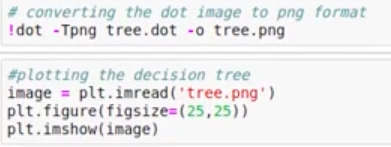

In [227]:
generate_submission_file('SampleSubmission_RF2.csv',rf_random.best_estimator_,test,testDF)

# Gradient Boost Regressor

In [229]:
 from sklearn.ensemble import GradientBoostingRegressor

In [575]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
GBR=GradientBoostingRegressor(**params)

In [576]:
regressionModelfit_CV(GBR,xtrainDF.columns, xtrainDF, ytrainDF)

fit_time =7.19
score_time =0.06
test_r2 =0.60
train_r2 =0.64
test_neg_mean_absolute_error =27.55
train_neg_mean_absolute_error =26.95
test_neg_mean_squared_error =1083.88
train_neg_mean_squared_error =1029.16


In [257]:
random_grid = {
               'max_features': ['ls', 'lad', 'huber', 'quantile'],
               'learning_rate': [0.01,0.1,0.5,1.0],
               'n_estimators': [100,250,1000,1500,2000],
               'max_depth': [4,8,12,16,20],
               'min_samples_split':[2,5,8,10,20],
               'min_samples_leaf':[1,3,5,10],
                'max_features':['auto','sqrt'],
                'alpha':[0.01,0.1,0.5,0.8,0.99]
               }
GBR_Estimator = RandomizedSearchCV(estimator = GBR, param_distributions = random_grid, n_iter = 50, cv = 5,
                               verbose=2, random_state=42, n_jobs = -1)
GBR_Estimator.fit(xtrainDF,ytrainDF)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 62.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.01,
                                                       loss='ls', max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                           

In [577]:
print(GBR_Estimator.best_params_)
print(GBR_Estimator.best_estimator_)
regressionModelfit_CV(GBR_Estimator.best_estimator_,xtrainDF.columns, xtrainDF, ytrainDF)


{'n_estimators': 2000, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.01, 'alpha': 0.01}
GradientBoostingRegressor(alpha=0.01, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=8,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
fit_time =5.46
score_time =0.24
test_r2 =0.59
train_r2 =0.66
test_neg_mean_absolute_error =27.73
train_neg_mean_absolute_error =26.50
test_neg_mean_squared_error =1094.87
train_neg_mean_squared_error 

In [578]:
generate_submission_file('SampleSubmission_GBM.csv',GBR_Estimator.best_estimator_,test,testDF)

array([1399.86679809, 1406.50848228,  690.77559229, ..., 1752.74554369,
       3730.39964736, 1328.95816396])

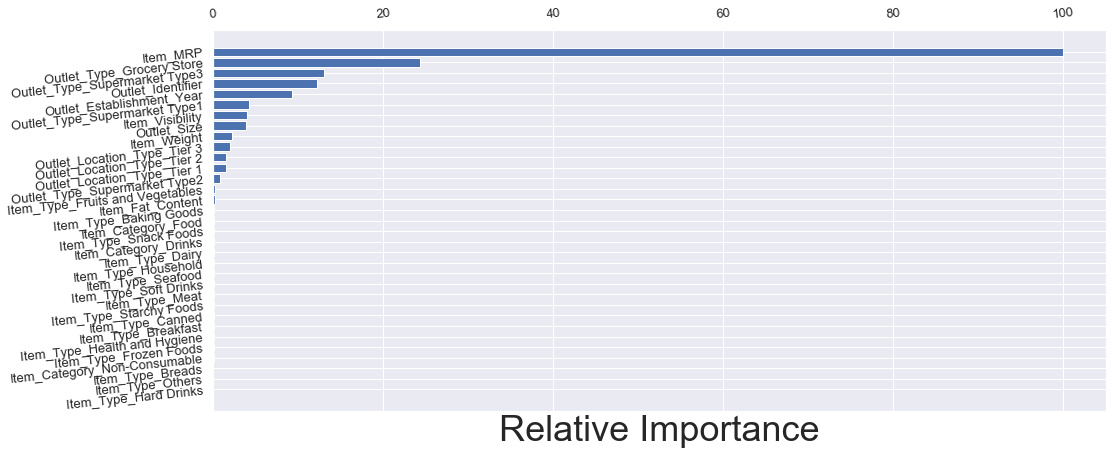

Index(['Item_Fat_Content', 'Item_Type_Fruits and Vegetables',
       'Outlet_Type_Supermarket Type2', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Item_Weight', 'Outlet_Size', 'Item_Visibility',
       'Outlet_Type_Supermarket Type1', 'Outlet_Establishment_Year',
       'Outlet_Identifier', 'Outlet_Type_Supermarket Type3',
       'Outlet_Type_Grocery Store', 'Item_MRP'],
      dtype='object')

In [301]:
feature_importance=GBR_Estimator.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
fig= plt.figure(figsize=(16,7))
plt.yticks(rotation=6,fontsize=13)
plt.xticks(rotation=6,fontsize=13)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, xtrainDF.columns[sorted_idx])

plt.xlabel('Relative Importance')
#plt.title('Variable Importance')
plt.show()
columns1=xtrainDF.columns[sorted_idx][18:]
columns1

In [293]:
regressionModelfit_CV(GBR_Estimator.best_estimator_,columns1, xtrainDF, ytrainDF)

fit_time =6.61
score_time =0.08
test_r2 =0.59
train_r2 =0.66
test_neg_mean_absolute_error =27.58
train_neg_mean_absolute_error =26.50
test_neg_mean_squared_error =1087.81
train_neg_mean_squared_error =998.18


In [424]:
GBR_Estimator.best_estimator_.fit(xtrainDF[columns1], ytrainDF)

GradientBoostingRegressor(alpha=0.01, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=8,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [426]:
pred_all['gbr']=GBR_Estimator.best_estimator_.predict(xtrainDF[columns1])
pred_all_test['gbr']=GBR_Estimator.best_estimator_.predict(testDF[columns1])

In [ ]:
GBR_Estimator.best_estimator_

In [296]:
generate_submission_file('SampleSubmission_GBM2.csv',GBR_Estimator.best_estimator_,test,testDF)

In [354]:
#pred_all,
#ytrainDF
dt1 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
regressionModelfit_CV(GBR,pred_all.columns, pred_all, ytrainDF)
#generate_submission_file('SampleSubmission_DT1.csv',dt,test,testDF)

fit_time =2.81
score_time =0.02
test_r2 =0.60
train_r2 =0.64
test_neg_mean_absolute_error =27.52
train_neg_mean_absolute_error =26.95
test_neg_mean_squared_error =1080.66
train_neg_mean_squared_error =1025.74


In [456]:
linear_model= LinearRegression()
#regressionModelfit_CV(linear_model,pred_all.columns[:], pred_all, ytrainDF)

In [586]:
testDF1=testDF.reset_index()
testDF1=testDF1[testDF1.columns[1:]]
pred_all=pred_all.round(2)
pred_all_test=pred_all_test.round(2).copy()
newtrain=pd.merge(xtrainDF[columns1], pred_all,left_index=True, right_index=True, how='inner')


In [587]:
newtest= pd.merge(testDF1[columns1],pred_all_test,left_index=True, right_index=True, how='inner')
newtest.shape,newtrain.shape,pred_all_test.shape,pred_all.shape,xtrainDF.shape,testDF.shape

((5681, 26), (8523, 26), (5681, 10), (8523, 10), (8523, 33), (5681, 33))

In [588]:
regressionModelfit_CV(GBR,newtrain.columns, newtrain, ytrainDF)

fit_time =7.66
score_time =0.08
test_r2 =0.70
train_r2 =0.76
test_neg_mean_absolute_error =25.69
train_neg_mean_absolute_error =24.66
test_neg_mean_squared_error =929.11
train_neg_mean_squared_error =841.32


In [589]:
generate_submission_file('SampleSubmission_stackingGBR.csv',GBR,test,newtest)

array([1563.61621213, 1251.14193102,  564.81387846, ..., 1736.27205822,
       3279.45444199, 1355.68228256])

In [603]:
#pred_all.head(3)


In [591]:
#pred_all_test.head(3)

In [605]:
pd.Series(GBR.predict(newtest))<33

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
5651    False
5652    False
5653    False
5654    False
5655    False
5656    False
5657    False
5658    False
5659    False
5660    False
5661    False
5662    False
5663    False
5664    False
5665    False
5666    False
5667    False
5668    False
5669    False
5670    False
5671    False
5672    False
5673    False
5674    False
5675    False
5676    False
5677    False
5678    False
5679    False
5680    False
Length: 5681, dtype: bool